# Evaluation for Fine Tuned Model ExpertQA Responses

In [1]:
# read in csv of fine-tuned model generated responses
# compare to revised_answer_string from ExpertQA dataset
# evaluation metrics: cosine and QAFactEval

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import csv

In [2]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
import bert_score

2024-05-04 14:10:17.773139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os

In [4]:
def parse_jsonl_for_fields(file_path, fields):
    """
    Parses a JSONL file and returns dictionaries for specified fields.

    :param file_path: Path to the JSONL file.
    :param fields: List of fields to extract data for.
    :return: A dictionary where each key is a field and the value is another dictionary
             of question-answer pairs for that field.
    """
    data = {field: {} for field in fields}
    
    with open(file_path, 'r') as file:
        for line in file:
            line_data = json.loads(line)
            field = line_data.get('metadata', {}).get('field')
            question = line_data.get('question')

            for answer_key in line_data.get('answers', {}):
                revised_answer = line_data['answers'][answer_key].get('revised_answer_string')
                if field in fields and question and revised_answer:
                    data[field][question] = revised_answer
                    break # There is only one revised answer per question

            if field in fields and question and revised_answer:
                data[field][question] = revised_answer

    return data

In [5]:
def parse_jsonl_for_fields_with_question_type(file_path, fields):
    """
    Parses a JSONL file and returns dictionaries for specified fields.

    :param file_path: Path to the JSONL file.
    :param fields: List of fields to extract data for.
    :return: A dictionary where each key is a field and the value is another dictionary
             containing question-answer pairs for that field, including question_type.
    """
    data = {field: {} for field in fields}
    
    with open(file_path, 'r') as file:
        for line in file:
            line_data = json.loads(line)
            field = line_data.get('metadata', {}).get('field')
            question_type = line_data.get('metadata', {}).get('question_type')
            if question_type:
                question_types = question_type.split('| ')
            else:
                question_types = []
            question = line_data.get('question')
            specific_field = line_data.get('metadata', {}).get('specific_field')

            for answer_key in line_data.get('answers', {}):
                revised_answer = line_data['answers'][answer_key].get('revised_answer_string')
                if field in fields and question and revised_answer:
                    if question not in data[field]:  # Check if question already exists in data
                        data[field][question] = {'revised_answer_string': revised_answer,
                                                 'question_type': question_types,
                                                 'specific_field': specific_field}
                    break  # There is only one revised answer per question

    return data

In [6]:
fields_of_interest = ["Healthcare / Medicine", "Law"]
parsed_data = parse_jsonl_for_fields('expertqa.jsonl', fields_of_interest)

# Display a small part of the data to verify
for field in parsed_data:
    print(f"Field: {field}, Number of entries: {len(parsed_data[field])}")
    for question in list(parsed_data[field].keys())[:2]:  # Displaying the first two entries for brevity
        print(f"  Question: {question}")
        print(f"  Answer: {parsed_data[field][question][:100]}...")  # Displaying first 100 characters of answer

Field: Healthcare / Medicine, Number of entries: 504
  Question: What are signs and study findings that would indicate follicular lymphoma has transformed to diffuse large B-cell lymphoma?
  Answer: Signs that might indicate a transformation of follicular lymphoma (FL) to diffuse large B-cell lymph...
  Question: A patient with a history of heart failure now presents with newly diagnosed metastatic HER2+ breast cancer. What is her recommended first line of treatment and what additional information should be discussed with the patient given her history of heart failure?
  Answer: According to the web search results, the recommended first line of treatment for HER2+ metastatic br...
Field: Law, Number of entries: 103
  Question: How will the estate of an individual who dies without a will be distributed?
  Answer: When an individual dies without a will, their estate is distributed according to the intestacy rules...
  Question: What are the requirements for claiming inheritance as per th

In [7]:
fields_of_interest = ["Healthcare / Medicine"]
parsed_data_with_question_type = parse_jsonl_for_fields_with_question_type('expertqa.jsonl', fields_of_interest)

# Display a small part of the data to verify
for field in parsed_data_with_question_type:
    print(f"Field: {field}, Number of entries: {len(parsed_data_with_question_type[field])}")
    for question, data in parsed_data_with_question_type[field].items():  
        print(f"  Question: {question}")
        print(f"  Question Type: {data['question_type']}")
        print(f"  Specific Field: {data['specific_field']}")
        print(f"  Answer: {data['revised_answer_string'][:100]}...")  # Displaying first 100 characters of answer

Field: Healthcare / Medicine, Number of entries: 504
  Question: What are signs and study findings that would indicate follicular lymphoma has transformed to diffuse large B-cell lymphoma?
  Question Type: ['Directed question that has a single unambiguous answer']
  Specific Field: Oncology
  Answer: Signs that might indicate a transformation of follicular lymphoma (FL) to diffuse large B-cell lymph...
  Question: A patient with a history of heart failure now presents with newly diagnosed metastatic HER2+ breast cancer. What is her recommended first line of treatment and what additional information should be discussed with the patient given her history of heart failure?
  Question Type: ['Advice or suggestions on how to approach a problem', 'Question that describes a hypothetical scenario and asks a question based on this scenario', 'Request for opinion on a topic']
  Specific Field: Oncology
  Answer: According to the web search results, the recommended first line of treatment for HER

# Structure of parsed data
 
 
{
    {'Healthcare / Medicine': {'Question': 'Answer', 'Question': 'Answer'},
    {'Law': {'Question': 'Answer', 'Question': 'Answer'},
}

In [8]:
def read_json_to_dict(file_path):
    """
    read json file and returns a dictionary where each question is a key and its corresponding answer is the value
    :param file_path: Path to the json file.
    :return: dictionary of questions and answers.
    """
    data = {}
    with open(file_path, 'r') as file:
        for line in file:
            question_answer = json.loads(line)
            for key, value in question_answer.items():
                data[key] = value
    return data

In [9]:
# Read the JSONL file and create the big dictionary
medical_chatbot_data = read_json_to_dict('medical_chatbot.json')

In [10]:
# verify count of medical chatbot questions and parsed data for medicine/healthcare are the same

print (len(parsed_data['Healthcare / Medicine']) == len(medical_chatbot_data))

True


# Structure of Medical Chatbot

{'Question': 'Answer', 'Question': 'Answer', 'Question': 'Answer'}

# Cosine Similarity

In [11]:
# Function to compute cosine similarity between two strings
def compute_cosine_similarity(string1, string2):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([string1, string2])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    return cosine_sim

In [12]:
# Function to compute cosine similarity for each question and write results to CSV
def compute_and_write_cosine_similarity(expert_data, model_data, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Key', 'Cosine Similarity']  # Define field names
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for question, answer_expert in expert_data.items():
            answer_model = model_data.get(question)
            if answer_model:
                similarity = compute_cosine_similarity(answer_expert, answer_model)
                writer.writerow({'Key': question, 'Cosine Similarity': similarity})

In [13]:
# Call the function to compute cosine similarity and write results to CSV
compute_and_write_cosine_similarity(parsed_data['Healthcare / Medicine'], medical_chatbot_data, 'medical_chatbot_cosine_similarity.csv')

# BERTScore

In [14]:
def compute_bert_score(reference_sentence, candidate_sentence):
    _, _, bert_score_f1 = bert_score.score([reference_sentence], [candidate_sentence], lang='en', model_type='bert-base-uncased')
    return bert_score_f1.item()  # Convert tensor to Python float

In [15]:
def compute_and_write_bert_score(expert_data, model_data, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Key', 'BERTScore']  # Define field names
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for question, answer_expert in expert_data.items():
            answer_model = model_data.get(question)
            if answer_model:
                bert_score = compute_bert_score(answer_expert, answer_model)
                writer.writerow({'Key': question, 'BERTScore': bert_score})

In [17]:
compute_and_write_bert_score(parsed_data['Healthcare / Medicine'], medical_chatbot_data, 'medical_chatbot_bert_score.csv')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Biomistral

In [10]:
biomistral_data = read_json_to_dict('biomistral.json')

In [11]:
compute_and_write_cosine_similarity(parsed_data['Healthcare / Medicine'], biomistral_data, 'biomistral_cosine_similarity.csv')

In [12]:
compute_and_write_bert_score(parsed_data['Healthcare / Medicine'], biomistral_data, 'biomistral_bert_score.csv')

# GPT

In [119]:
gpt_data = read_json_to_dict('llmproject/results.json')

In [120]:
compute_and_write_cosine_similarity(parsed_data['Healthcare / Medicine'], gpt_data, 'gpt_cosine_similarity.csv')

In [121]:
compute_and_write_bert_score(parsed_data['Healthcare / Medicine'], gpt_data, 'gpt_bert_score.csv')

# Mistral

In [16]:
mistral_data = read_json_to_dict('mistral.json')

In [17]:
compute_and_write_cosine_similarity(parsed_data['Healthcare / Medicine'], mistral_data, 'mistral_cosine_similarity.csv')

In [18]:
compute_and_write_bert_score(parsed_data['Healthcare / Medicine'], mistral_data, 'mistral_bert_score.csv')

# Join Data Results with Question_Type

- 'medical_chatbot_cosine_similarity.csv'
- 'medical_chatbot_bert_score.csv'
- 'biomistral_cosine_similarity.csv'
- 'biomistral_bert_score.csv'
- 'mistral_cosine_similarity.csv'
- 'mistral_bert_score.csv'

Read all of the csvs and then join with parsed_data_with_question_type by question and then write to new csv

In [19]:
def add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data):
    """
    Adds question types to a CSV file based on the 'Key' column and writes the updated data to a new CSV file.

    :param input_csv_path: Path to the input CSV file.
    :param output_csv_path: Path to the output CSV file.
    :param parsed_data: Parsed data containing question-answer pairs with question types.
    """
    with open(input_csv_path, 'r', newline='') as infile, open(output_csv_path, 'w', newline='') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['Question Type', 'Specific Field']
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            key = row['Key']
            question_types = []
            specific_field = None
            for field, data in parsed_data.items():
                for question, q_data in data.items():
                    if question == key:
                        question_types.extend(q_data['question_type'])
                        specific_field = q_data['specific_field']
                        break  # No need to continue once we found the specific field

            row['Question Type'] = question_types
            row['Specific Field'] = specific_field
            writer.writerow(row)

In [36]:
# Example usage
input_csv_path = 'medical_chatbot_cosine_similarity.csv'
output_csv_path = 'medical_chatbot_cosine_similarity_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

In [37]:
# Example usage
input_csv_path = 'medical_chatbot_bert_score.csv'
output_csv_path = 'medical_chatbot_bert_score_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

In [38]:
# Example usage
input_csv_path = 'biomistral_cosine_similarity.csv'
output_csv_path = 'biomistral_cosine_similarity_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

In [39]:
# Example usage
input_csv_path = 'biomistral_bert_score.csv'
output_csv_path = 'biomistral_bert_score_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

In [122]:
input_csv_path = 'gpt_cosine_similarity.csv'
output_csv_path = 'gpt_cosine_similarity_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

In [123]:
input_csv_path = 'gpt_bert_score.csv'
output_csv_path = 'gpt_bert_score_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

In [20]:
input_csv_path = 'mistral_bert_score.csv'
output_csv_path = 'mistral_bert_score_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

In [21]:
input_csv_path = 'mistral_cosine_similarity.csv'
output_csv_path = 'mistral_cosine_similarity_types.csv'
add_question_types_to_csv(input_csv_path, output_csv_path, parsed_data_with_question_type)

# Graphing

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
cosine_medchat = pd.read_csv("llmproject/cosine_bert_with_question_types/medical_chatbot_cosine_similarity_types.csv")
cosine_biomistral = pd.read_csv("llmproject/cosine_bert_with_question_types/biomistral_cosine_similarity_types.csv")
bert_medchat = pd.read_csv("llmproject/cosine_bert_with_question_types/medical_chatbot_bert_score_types.csv")
bert_biomistral = pd.read_csv("llmproject/cosine_bert_with_question_types/biomistral_bert_score_types.csv")

In [24]:
cosine_gpt = pd.read_csv("gpt_cosine_similarity_types.csv")
bert_gpt = pd.read_csv("gpt_bert_score_types.csv")

In [25]:
cosine_mistral = pd.read_csv("mistral_cosine_similarity_types.csv")
bert_mistral = pd.read_csv("mistral_bert_score_types.csv")

In [26]:
print(cosine_medchat.columns)
print(bert_medchat.columns)
print(bert_gpt.columns)

Index(['Key', 'Cosine Similarity', 'Question Type', 'Specific Field'], dtype='object')
Index(['Key', 'BERTScore', 'Question Type', 'Specific Field'], dtype='object')
Index(['Key', 'BERTScore', 'Question Type', 'Specific Field'], dtype='object')


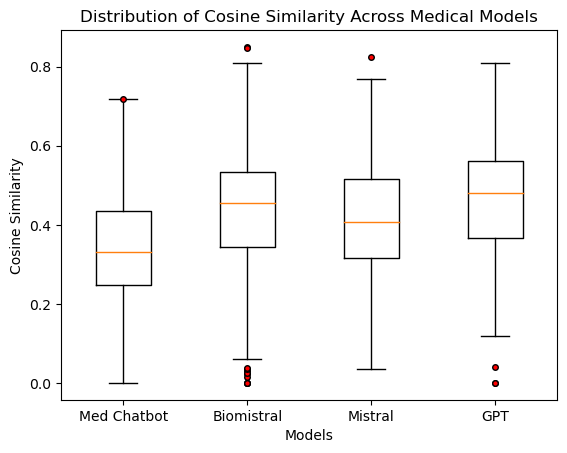

In [69]:
# cosine similarity graphs

# Example data: Replace these lists with your actual BLEU scores
medchatbot_cosine = cosine_medchat['Cosine Similarity']
biomistral_cosine = cosine_biomistral['Cosine Similarity']
mistral_cosine = cosine_mistral['Cosine Similarity']
gpt_cosine = cosine_gpt['Cosine Similarity']

data = [medchatbot_cosine ,biomistral_cosine, mistral_cosine, gpt_cosine ]
plt.boxplot(data, labels=['Med Chatbot', 'Biomistral', 'Mistral','GPT'],flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'red'})
plt.ylabel('Cosine Similarity')
plt.xlabel('Models')
plt.title('Distribution of Cosine Similarity Across Medical Models')
plt.savefig('cosine_similarity_score_plot.jpg')
plt.show()

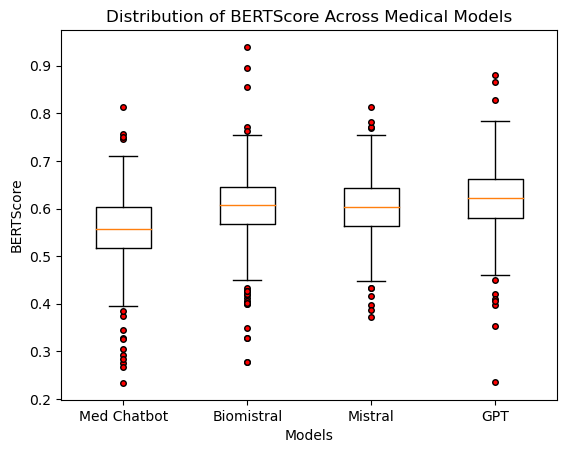

In [70]:
# cosine similarity graphs

# Example data: Replace these lists with your actual BLEU scores
medchatbot_bert = bert_medchat['BERTScore']
biomistral_bert = bert_biomistral['BERTScore']
mistral_bert = bert_mistral['BERTScore']
gpt_bert = bert_gpt['BERTScore']

data = [medchatbot_bert ,biomistral_bert, mistral_bert, gpt_bert]
plt.boxplot(data, labels=['Med Chatbot', 'Biomistral', 'Mistral', 'GPT'],flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'red'})
plt.ylabel('BERTScore')
plt.xlabel('Models')
plt.title('Distribution of BERTScore Across Medical Models')
plt.savefig('bert_score_plot.jpg')
plt.show()

In [29]:
# create dataframe with exploded question types

def create_dataframe_with_repeated_question_types(og_df, name):
    og_df_copy = og_df.copy()
    og_df_copy['Question Type'] = og_df_copy['Question Type'].apply(eval)
    exploded_df = og_df_copy.explode('Question Type')
    num_questions = len(exploded_df)
    print(f"Original dataframe: {name}, Number of questions: {num_questions}")
    return exploded_df

In [30]:
cosine_medchat_exploded = create_dataframe_with_repeated_question_types(cosine_medchat, "Medical Chatbot Cosine")
cosine_biomistral_exploded = create_dataframe_with_repeated_question_types(cosine_biomistral, "Biomistral Cosine")

bert_medchat_exploded = create_dataframe_with_repeated_question_types(bert_medchat, "Medical Chatbot BERTScore")
bert_biomistral_exploded = create_dataframe_with_repeated_question_types(bert_biomistral, "Biomistral BERTScore")

cosine_gpt_exploded = create_dataframe_with_repeated_question_types(cosine_gpt, "GPT Cosine")
bert_gpt_exploded = create_dataframe_with_repeated_question_types(bert_gpt, "GPT BERTScore")

bert_mistral_exploded = create_dataframe_with_repeated_question_types(bert_mistral, "Mistral BERTScore")
cosine_mistral_exploded = create_dataframe_with_repeated_question_types(cosine_mistral, "Mistral Cosine")

Original dataframe: Medical Chatbot Cosine, Number of questions: 680
Original dataframe: Biomistral Cosine, Number of questions: 682
Original dataframe: Medical Chatbot BERTScore, Number of questions: 682
Original dataframe: Biomistral BERTScore, Number of questions: 682
Original dataframe: GPT Cosine, Number of questions: 682
Original dataframe: GPT BERTScore, Number of questions: 682
Original dataframe: Mistral BERTScore, Number of questions: 682
Original dataframe: Mistral Cosine, Number of questions: 682


In [58]:
def plot_by_question_type(exploded_df, score, model):
    plt.figure(figsize=(20, 8))
    sns.boxplot(x='Question Type', y=score, data=exploded_df, color='skyblue')
    plt.title(f"{score} Distribution by Question Type for {model}", fontsize=24)
    plt.xlabel('Question Type', fontsize=20)
    plt.ylabel(f"{score}", fontsize=20)
    plt.xticks(rotation=35, ha="right", fontsize=16)  # Adjust font size as needed
    plt.yticks(fontsize=16)  # Adjust font size as needed
    plt.savefig(f"{score}_across_question_types_{model}.pdf")
    plt.show()

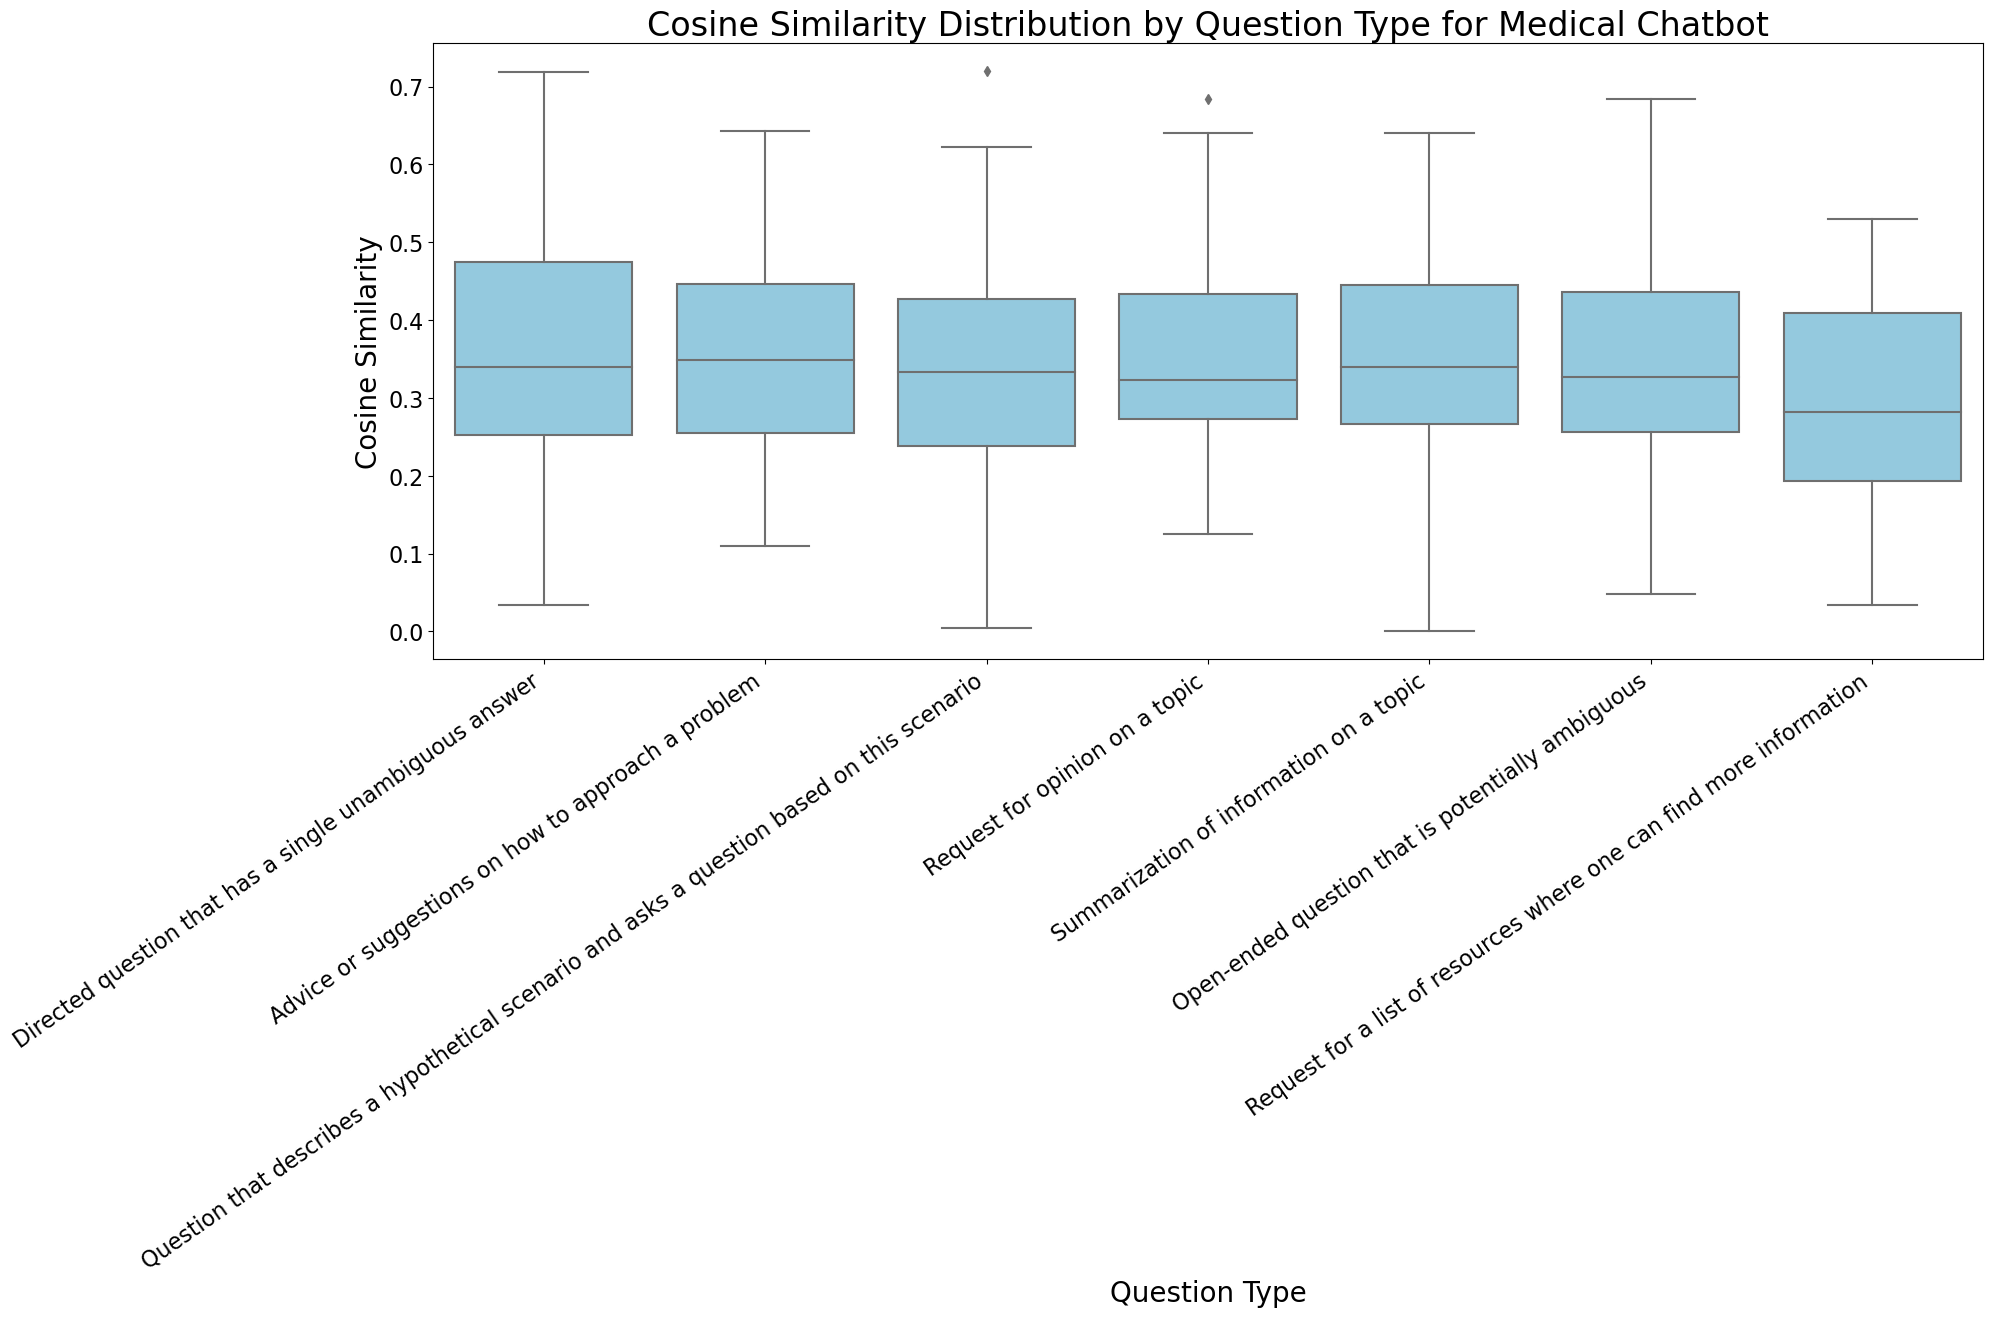

In [59]:
plot_by_question_type(cosine_medchat_exploded, "Cosine Similarity", "Medical Chatbot")

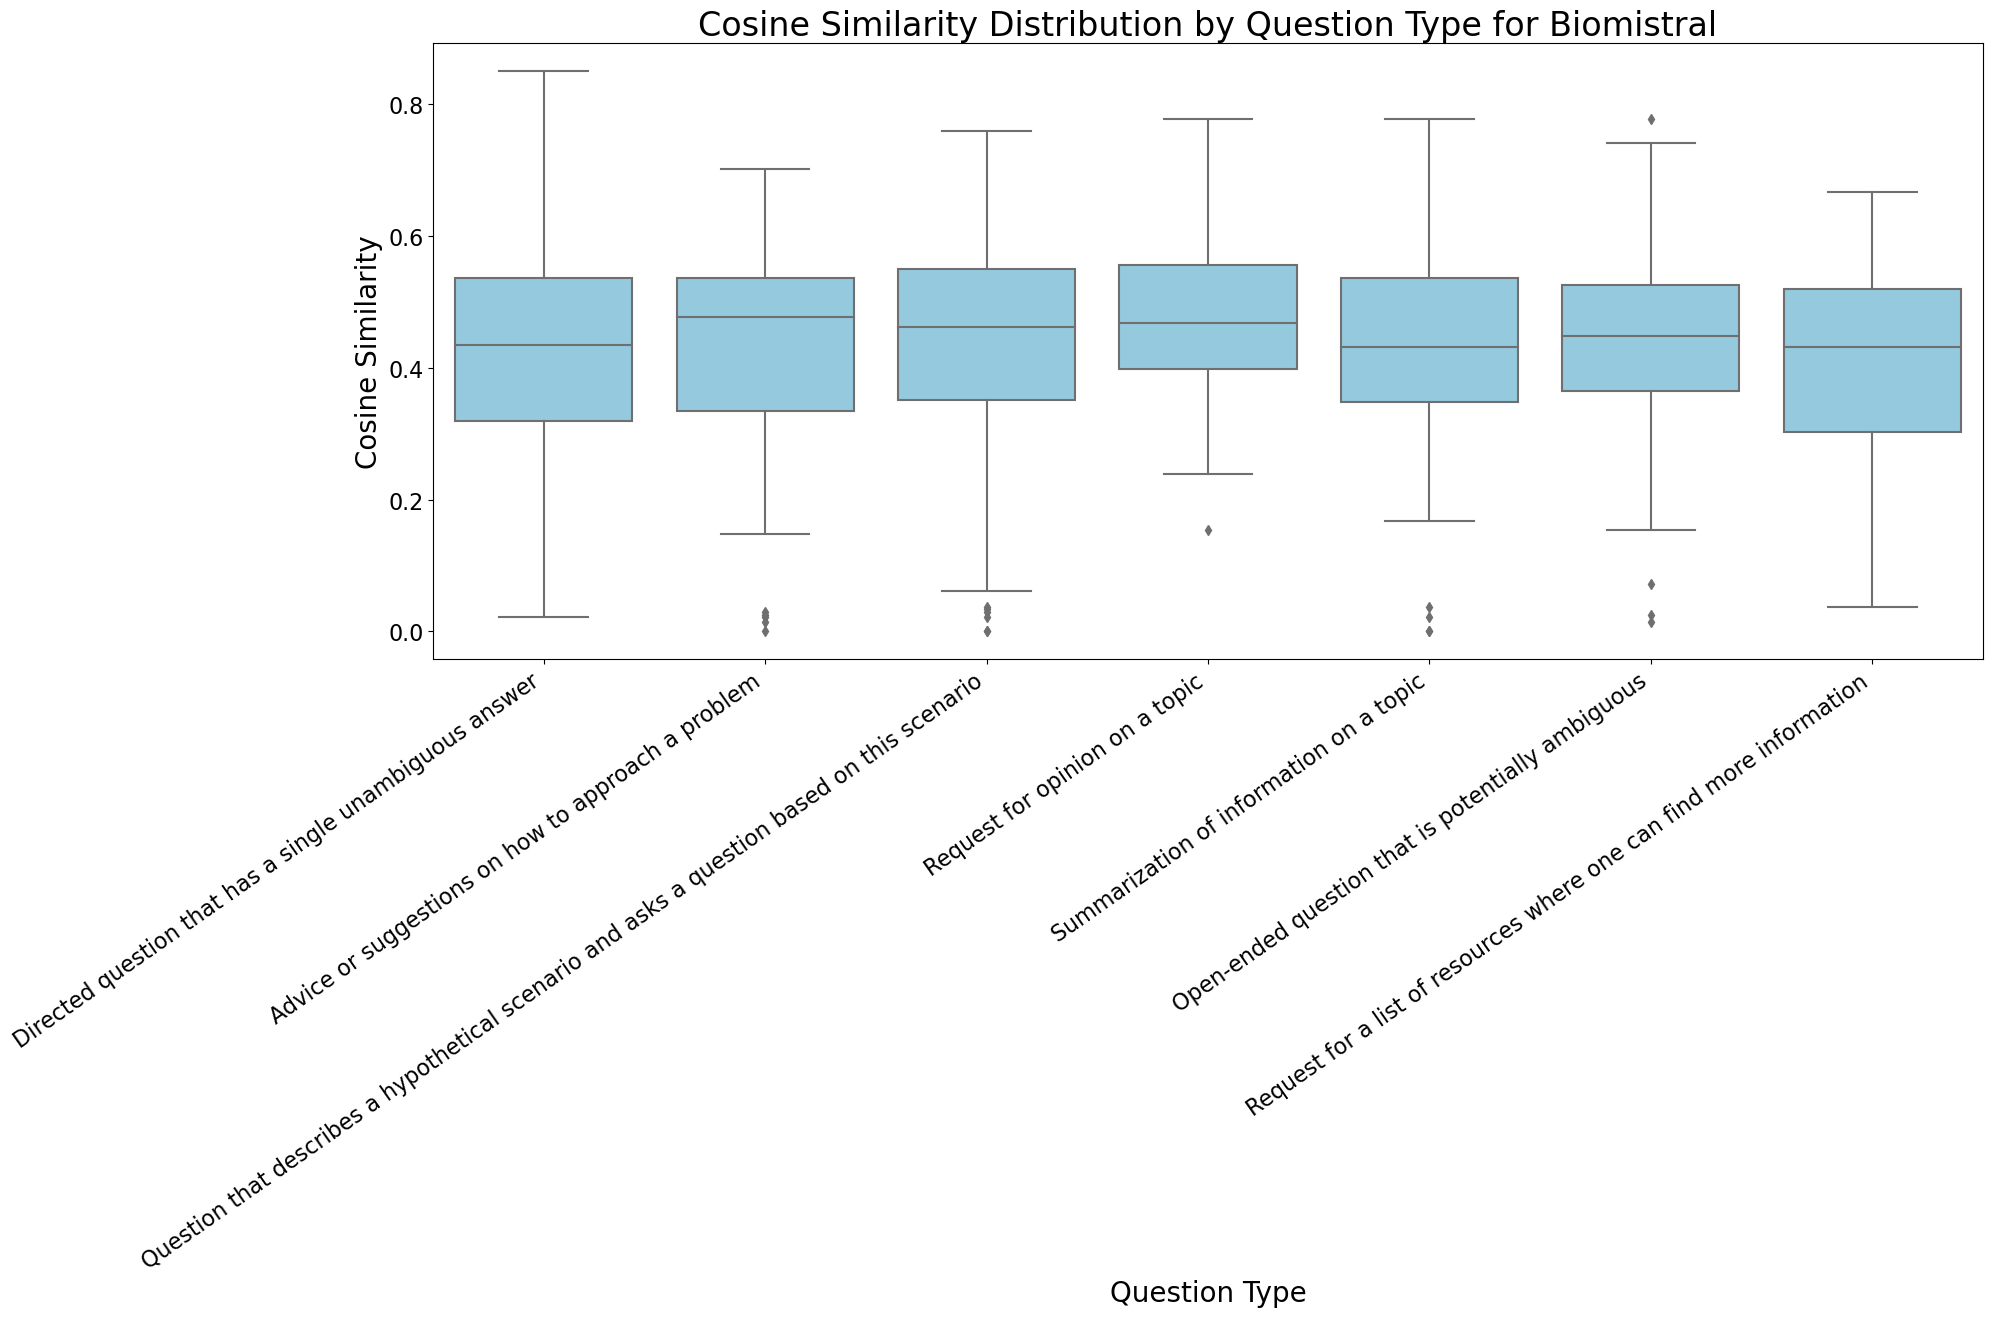

In [60]:
plot_by_question_type(cosine_biomistral_exploded, "Cosine Similarity", "Biomistral")

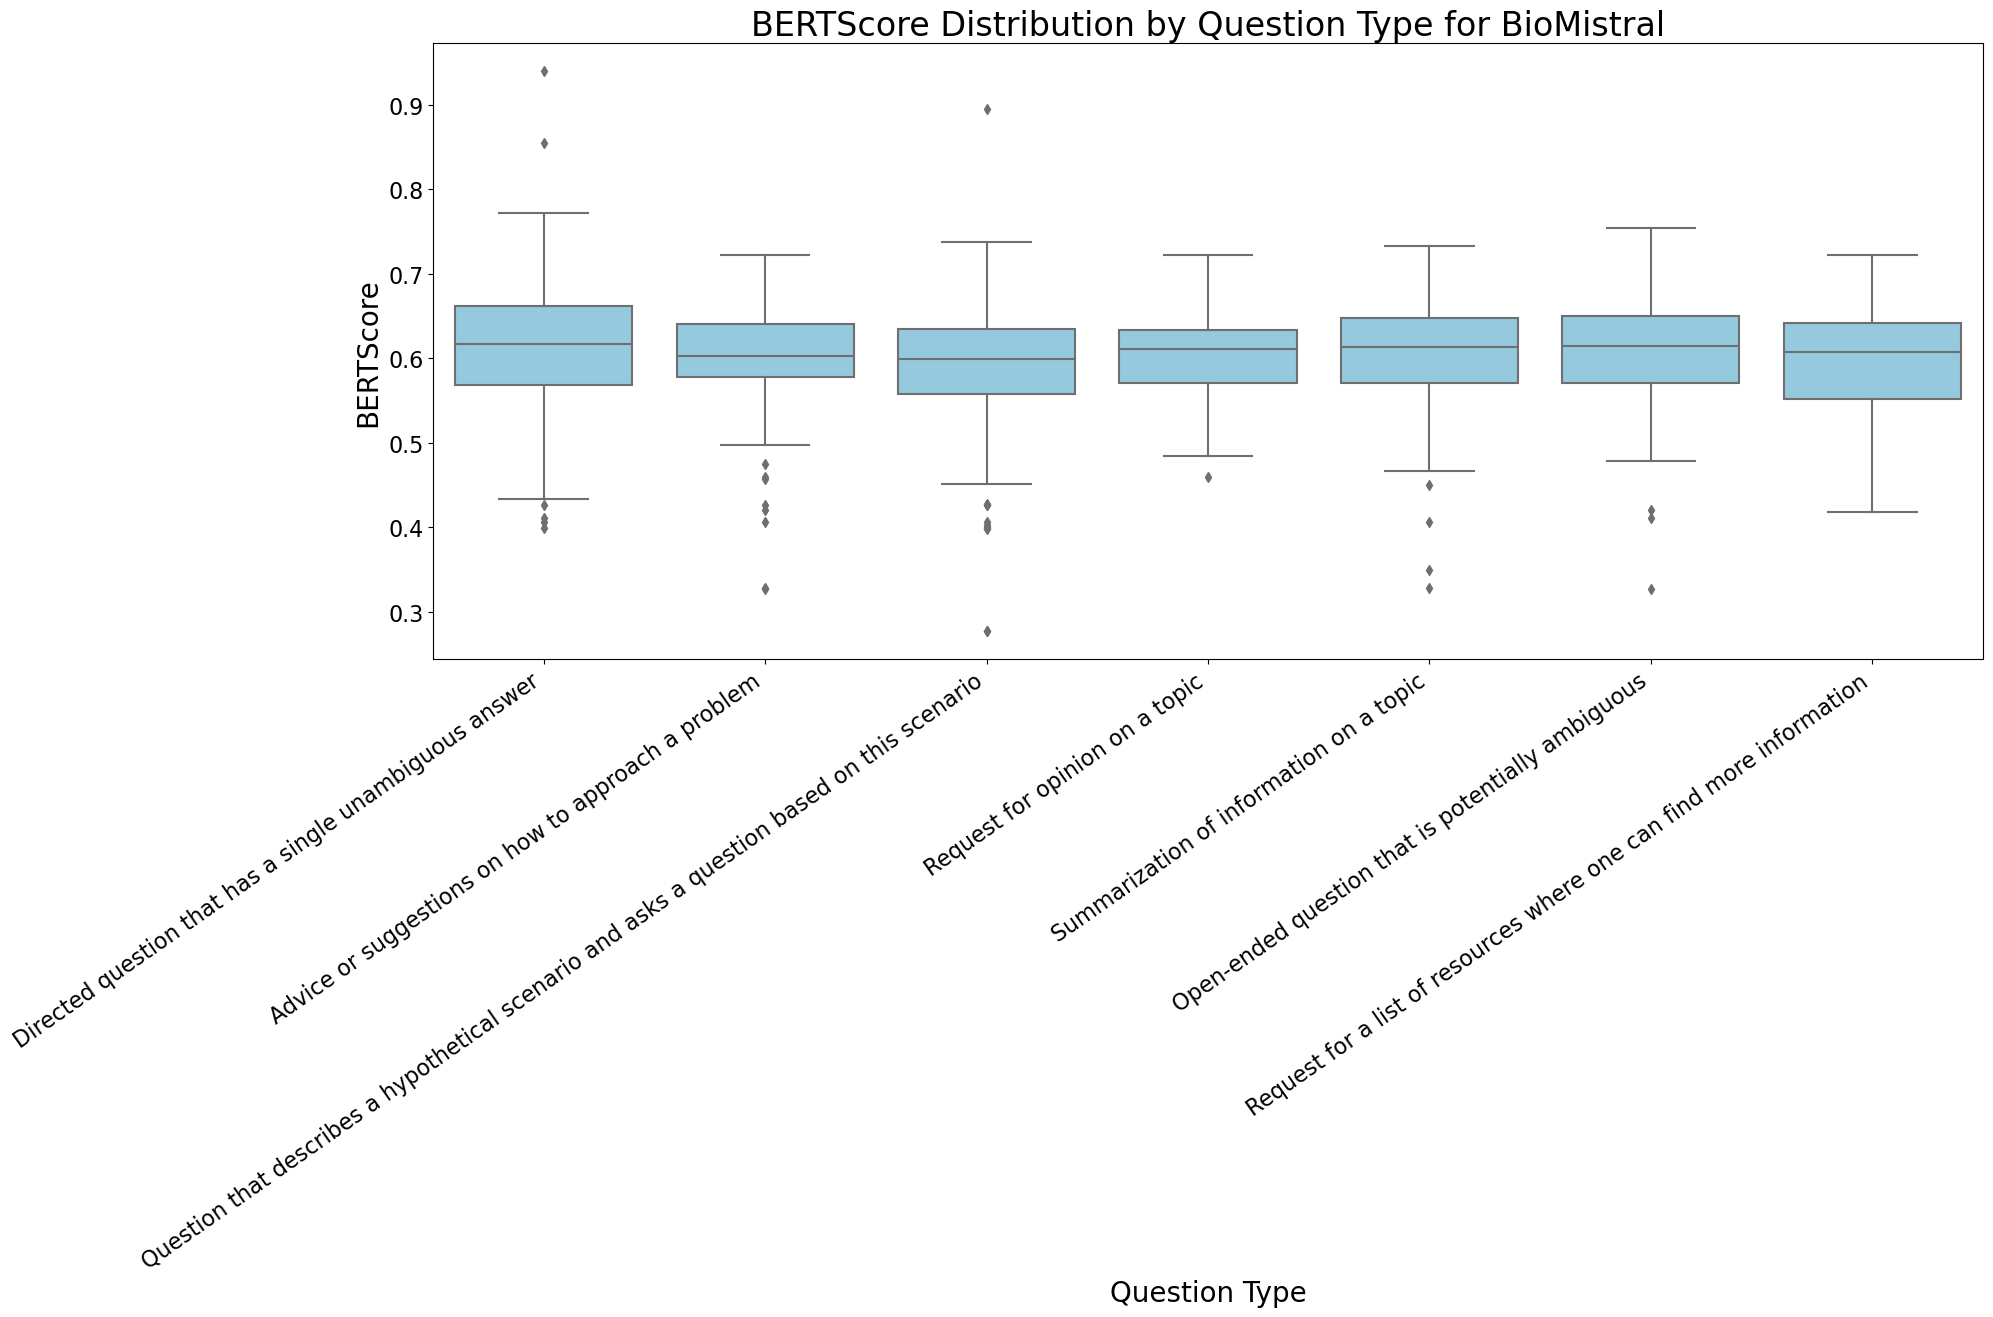

In [61]:
plot_by_question_type(bert_biomistral_exploded, "BERTScore", "BioMistral")

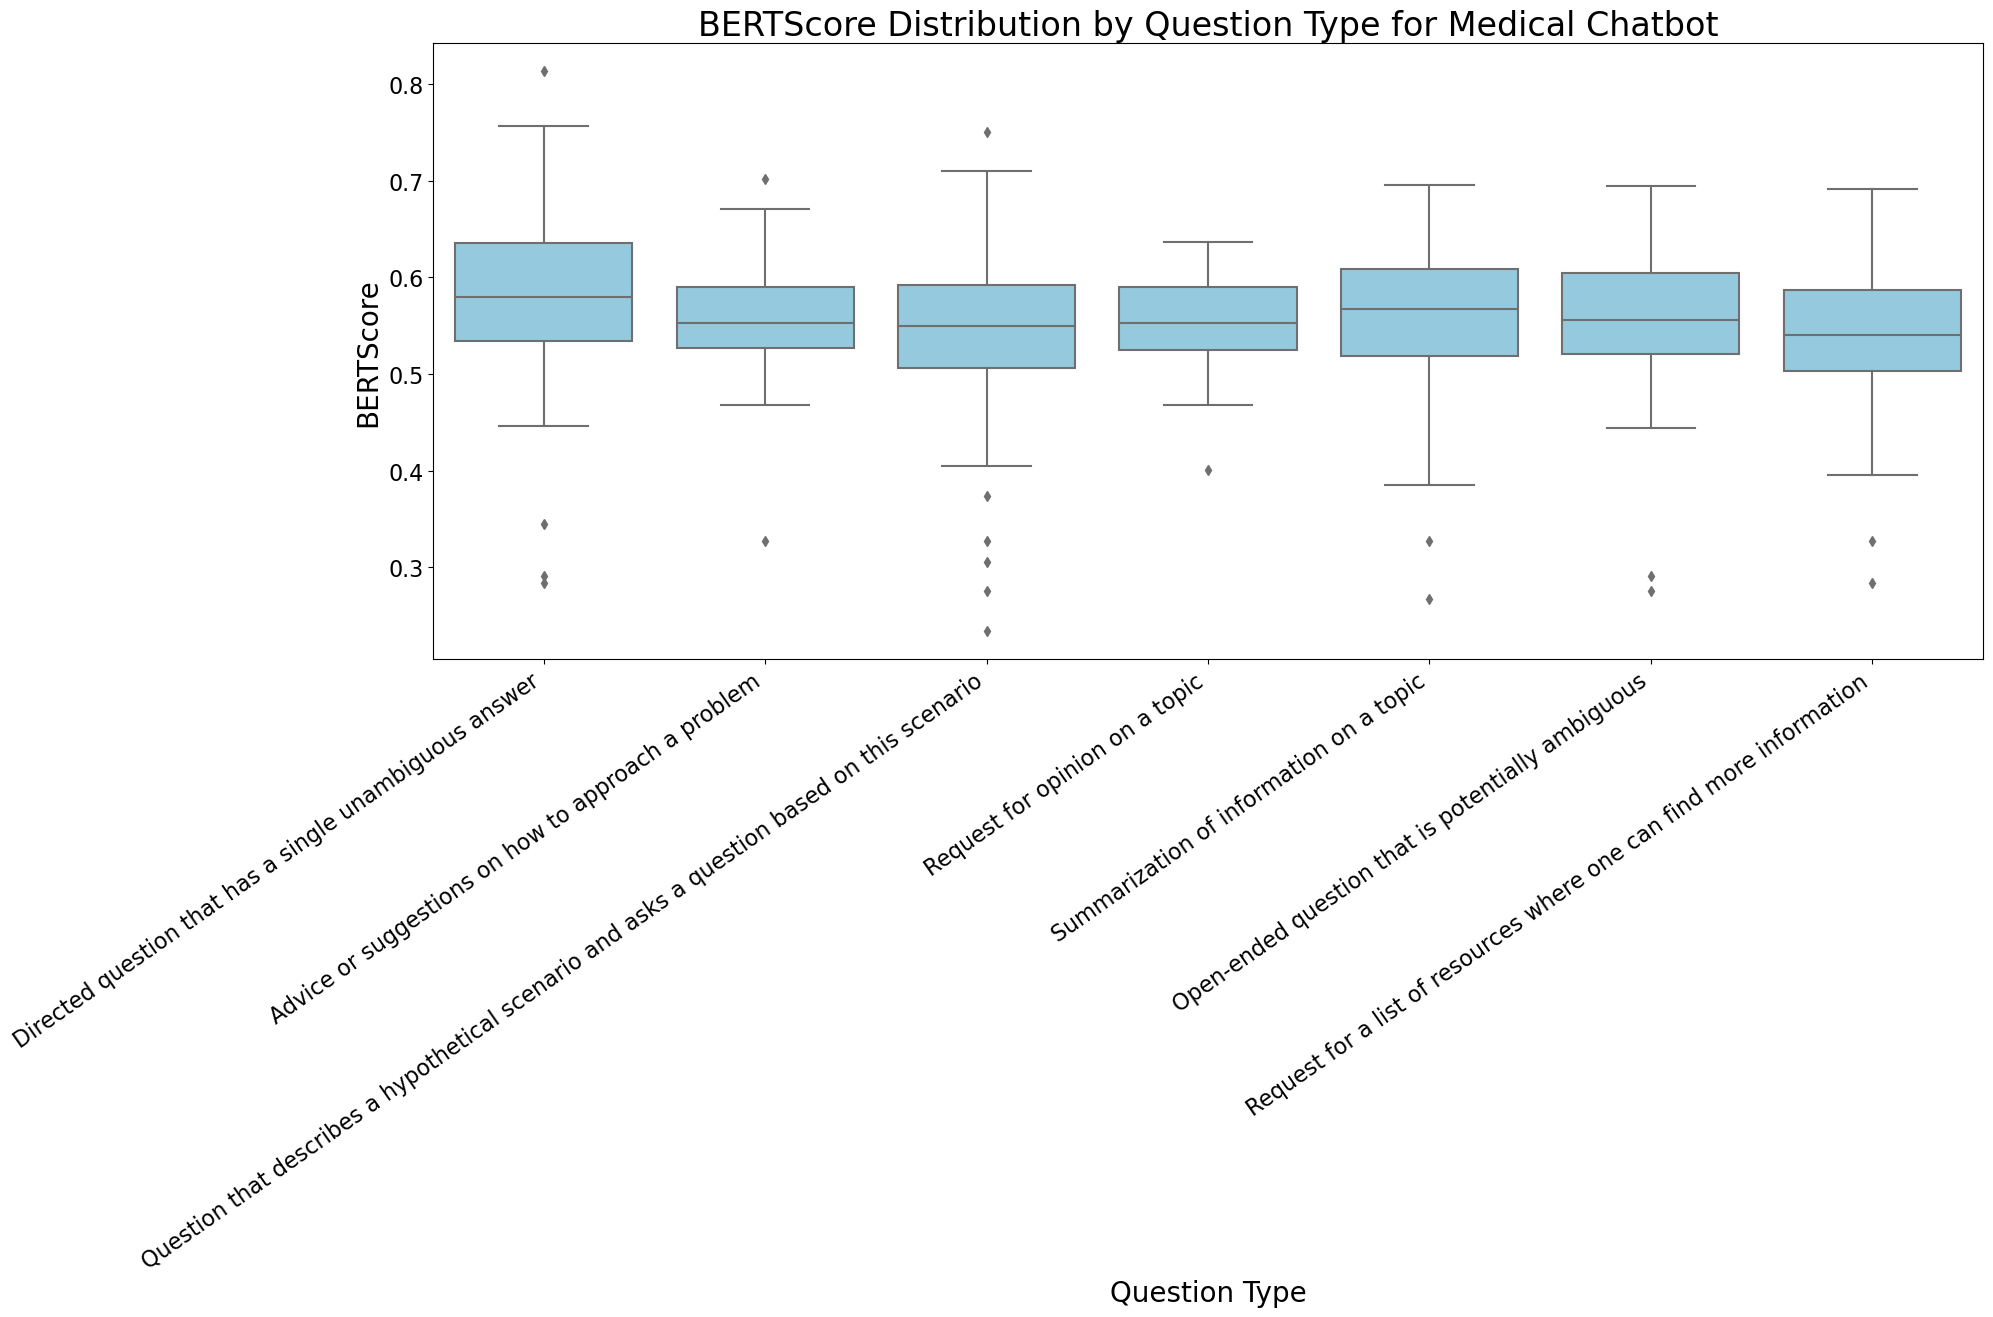

In [62]:
plot_by_question_type(bert_medchat_exploded, "BERTScore", "Medical Chatbot")

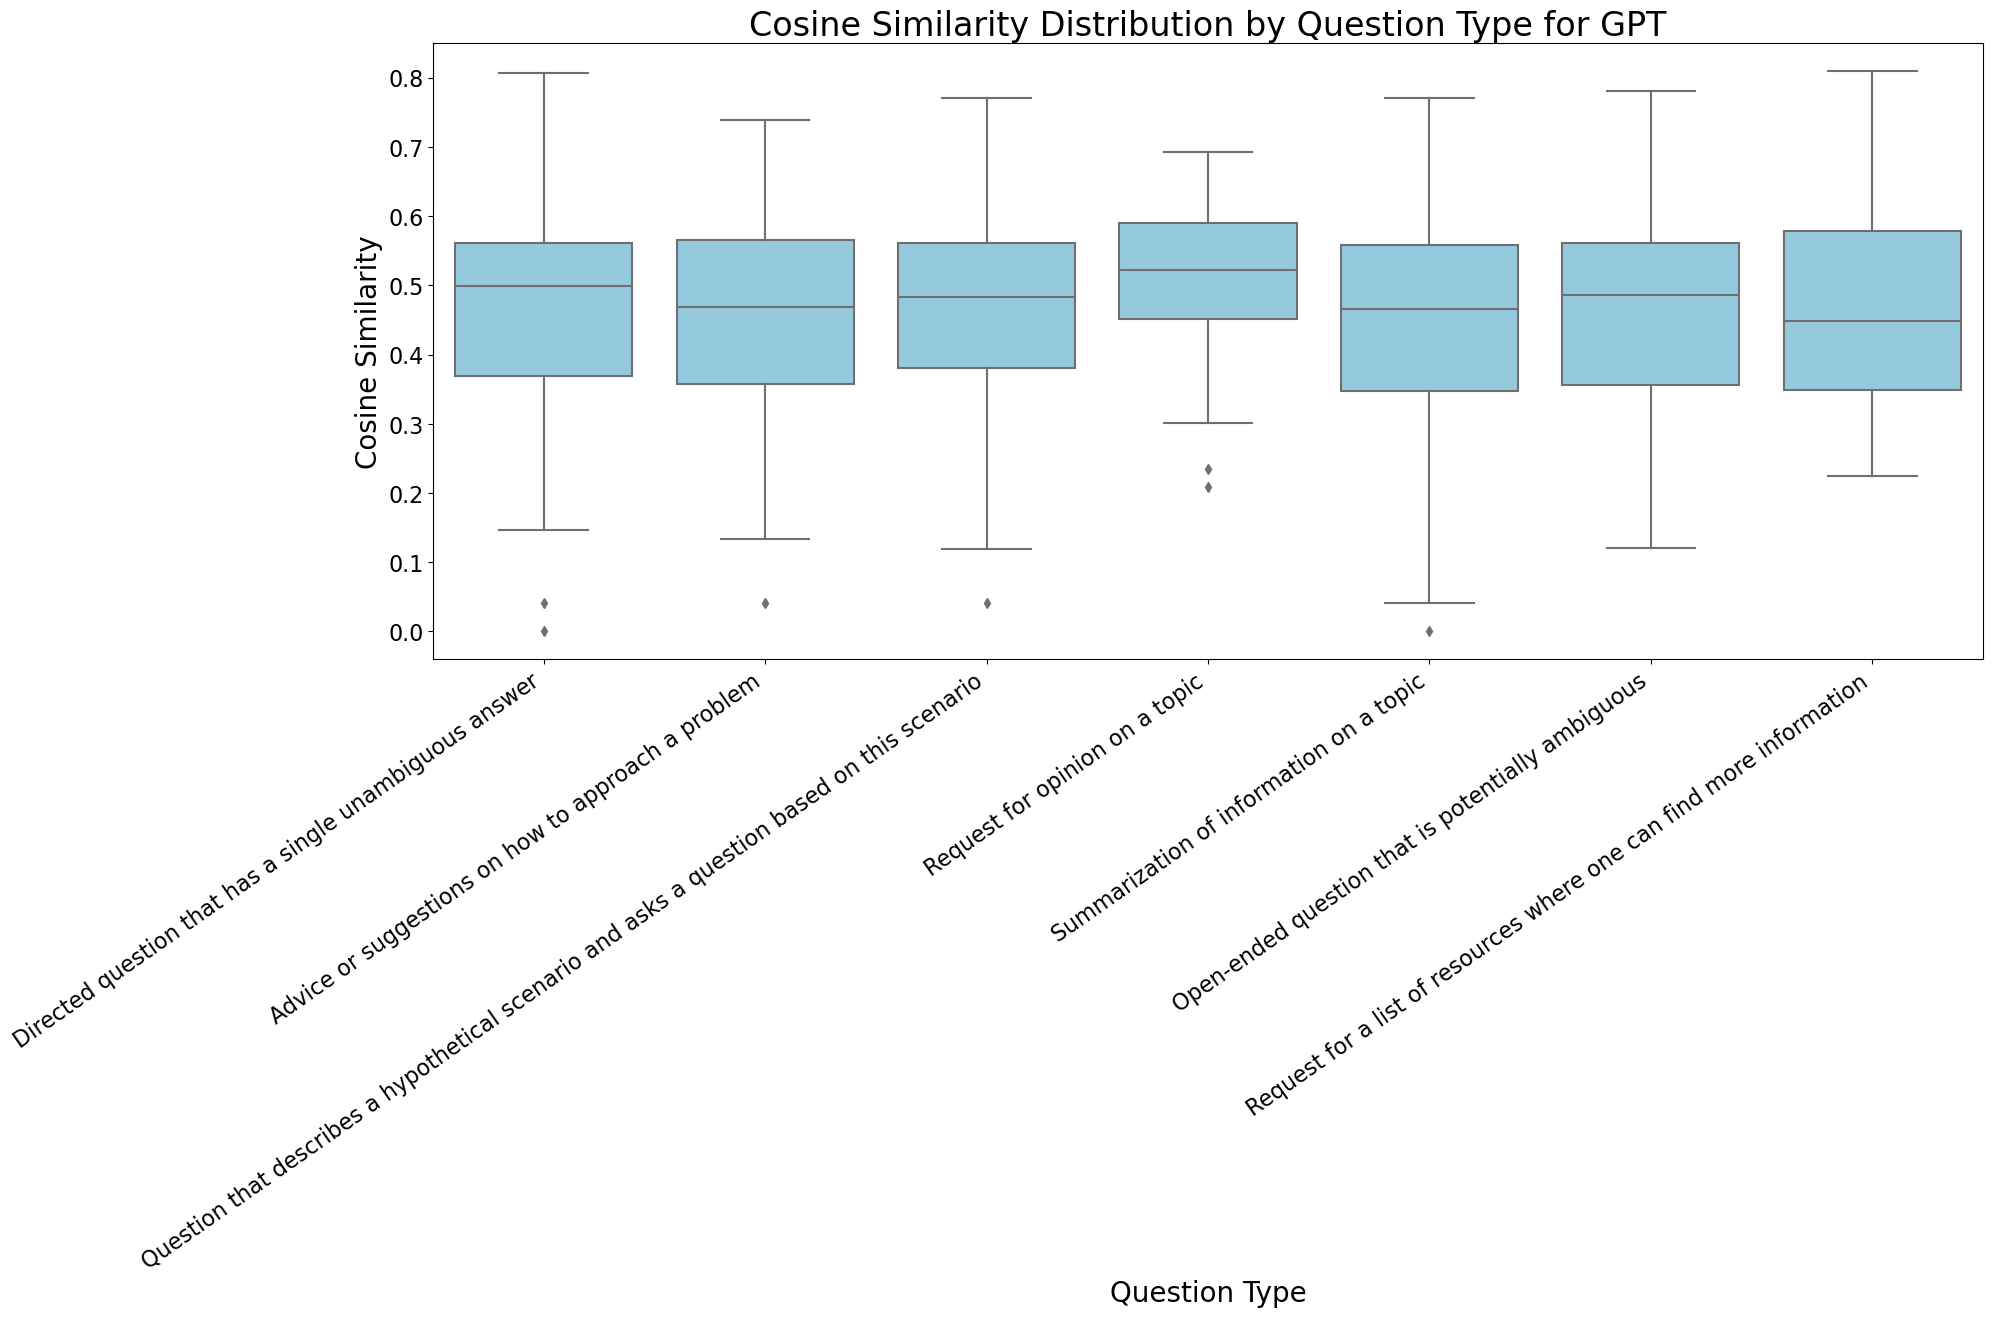

In [63]:
plot_by_question_type(cosine_gpt_exploded, "Cosine Similarity", "GPT")

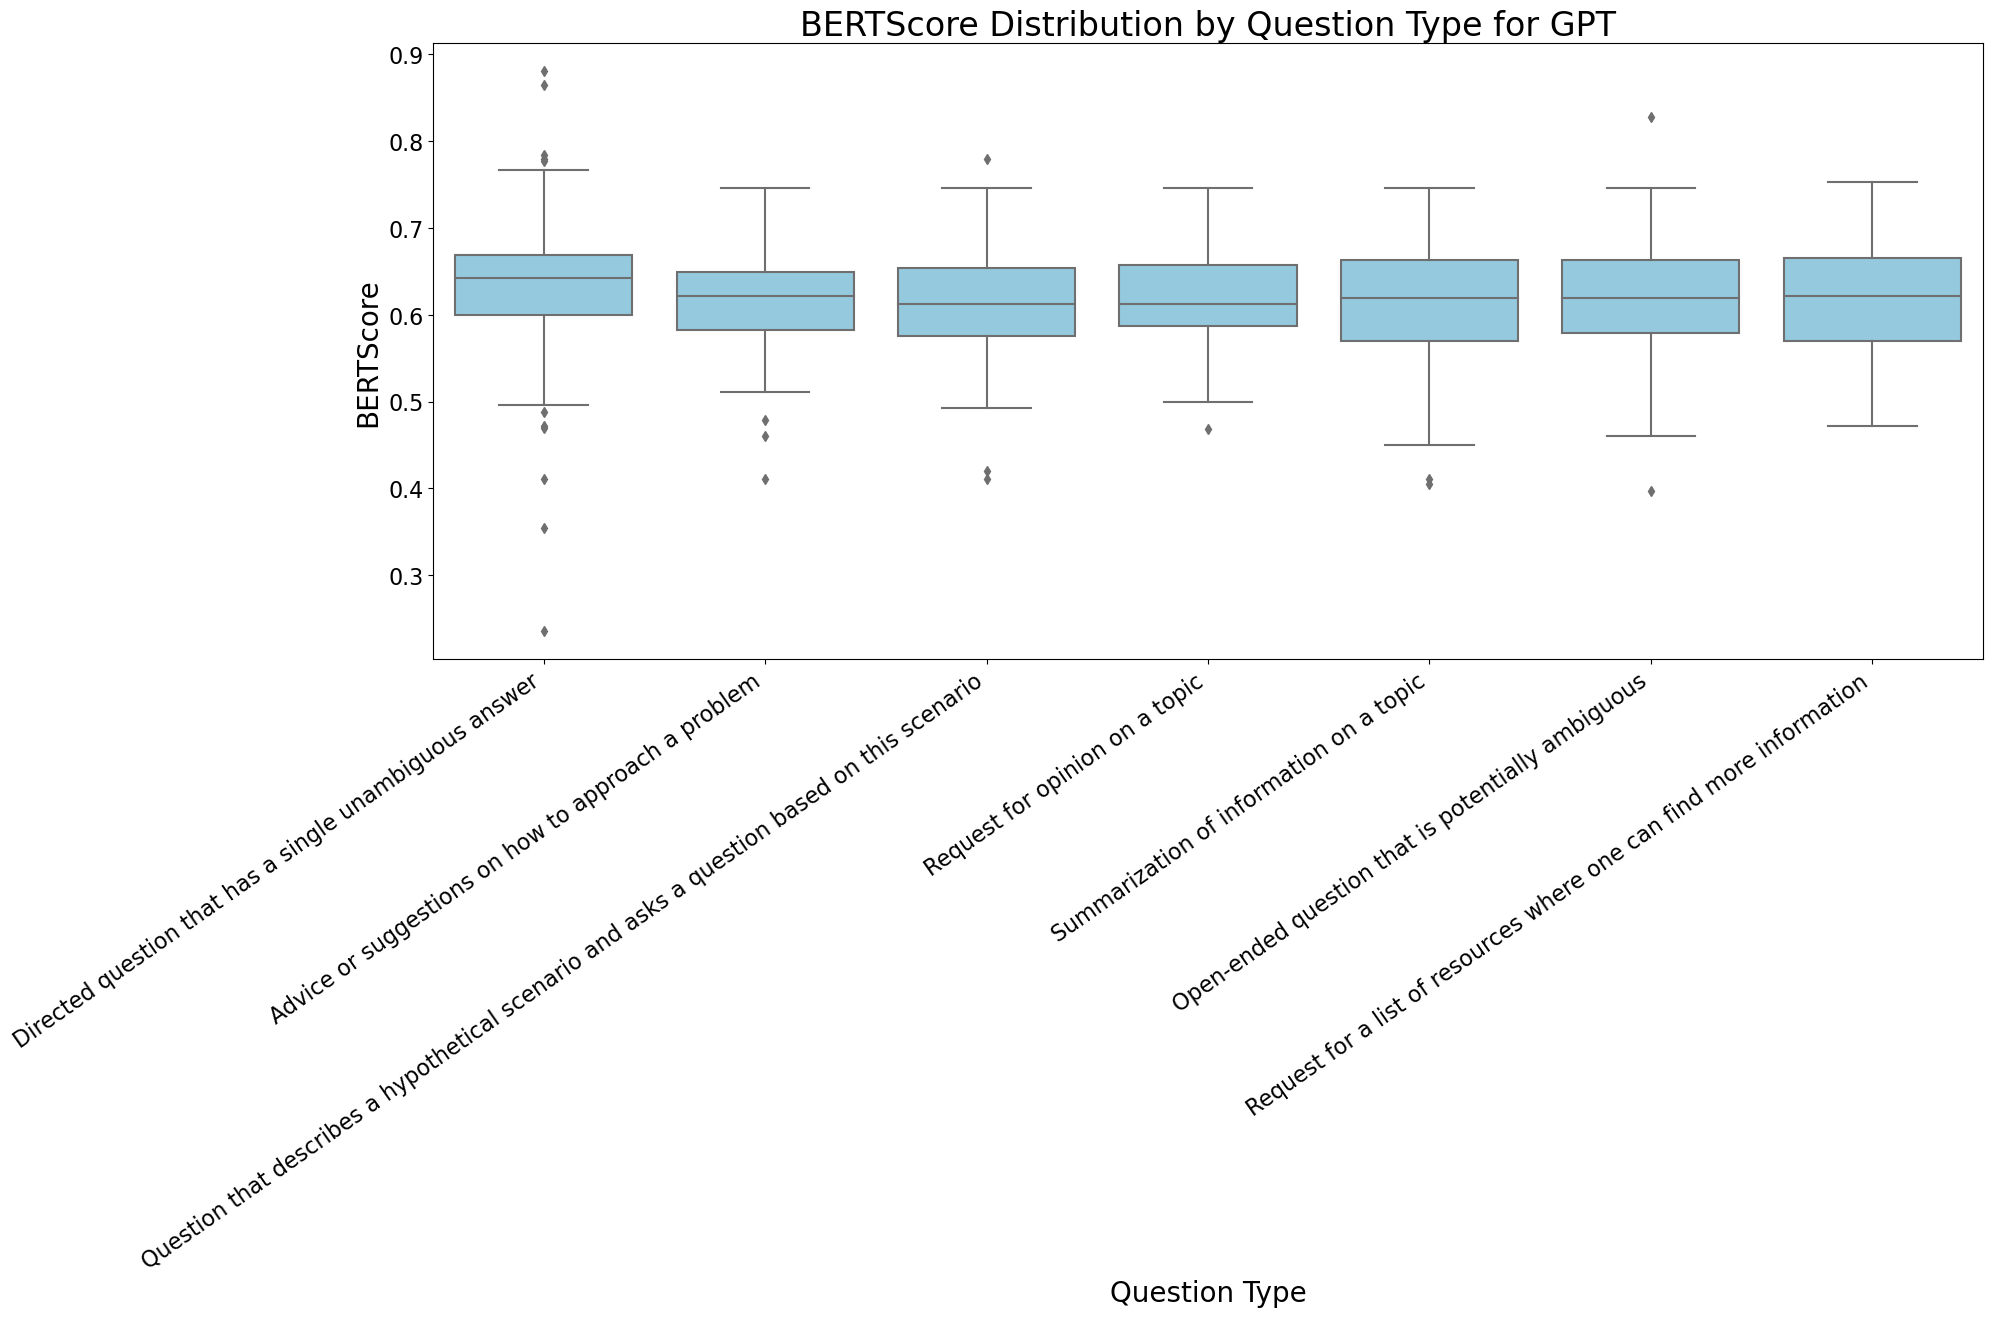

In [64]:
plot_by_question_type(bert_gpt_exploded, "BERTScore", "GPT")

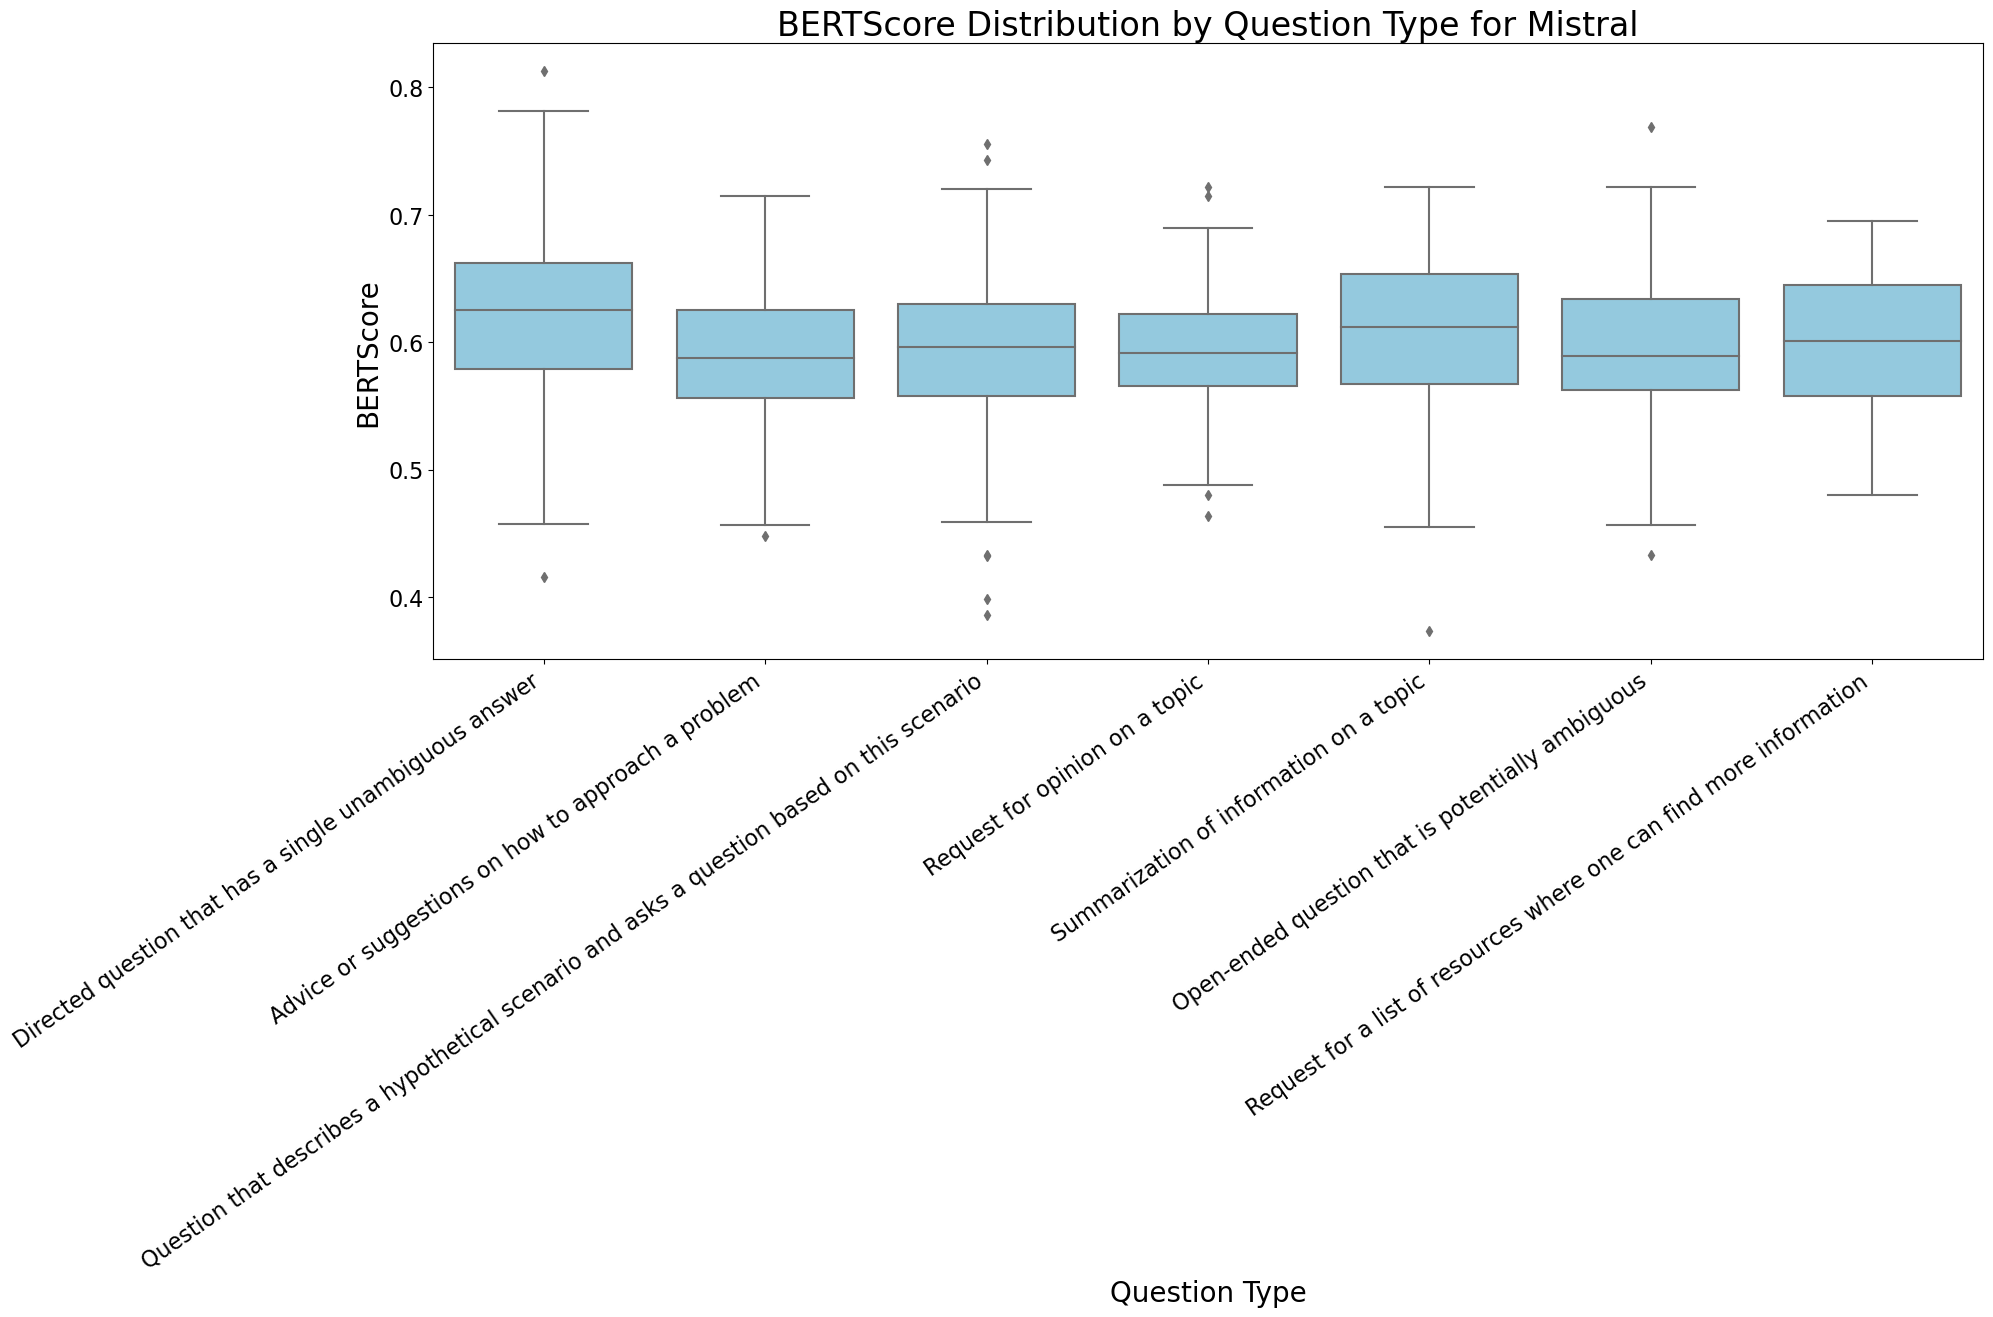

In [65]:
plot_by_question_type(bert_mistral_exploded, "BERTScore", "Mistral")

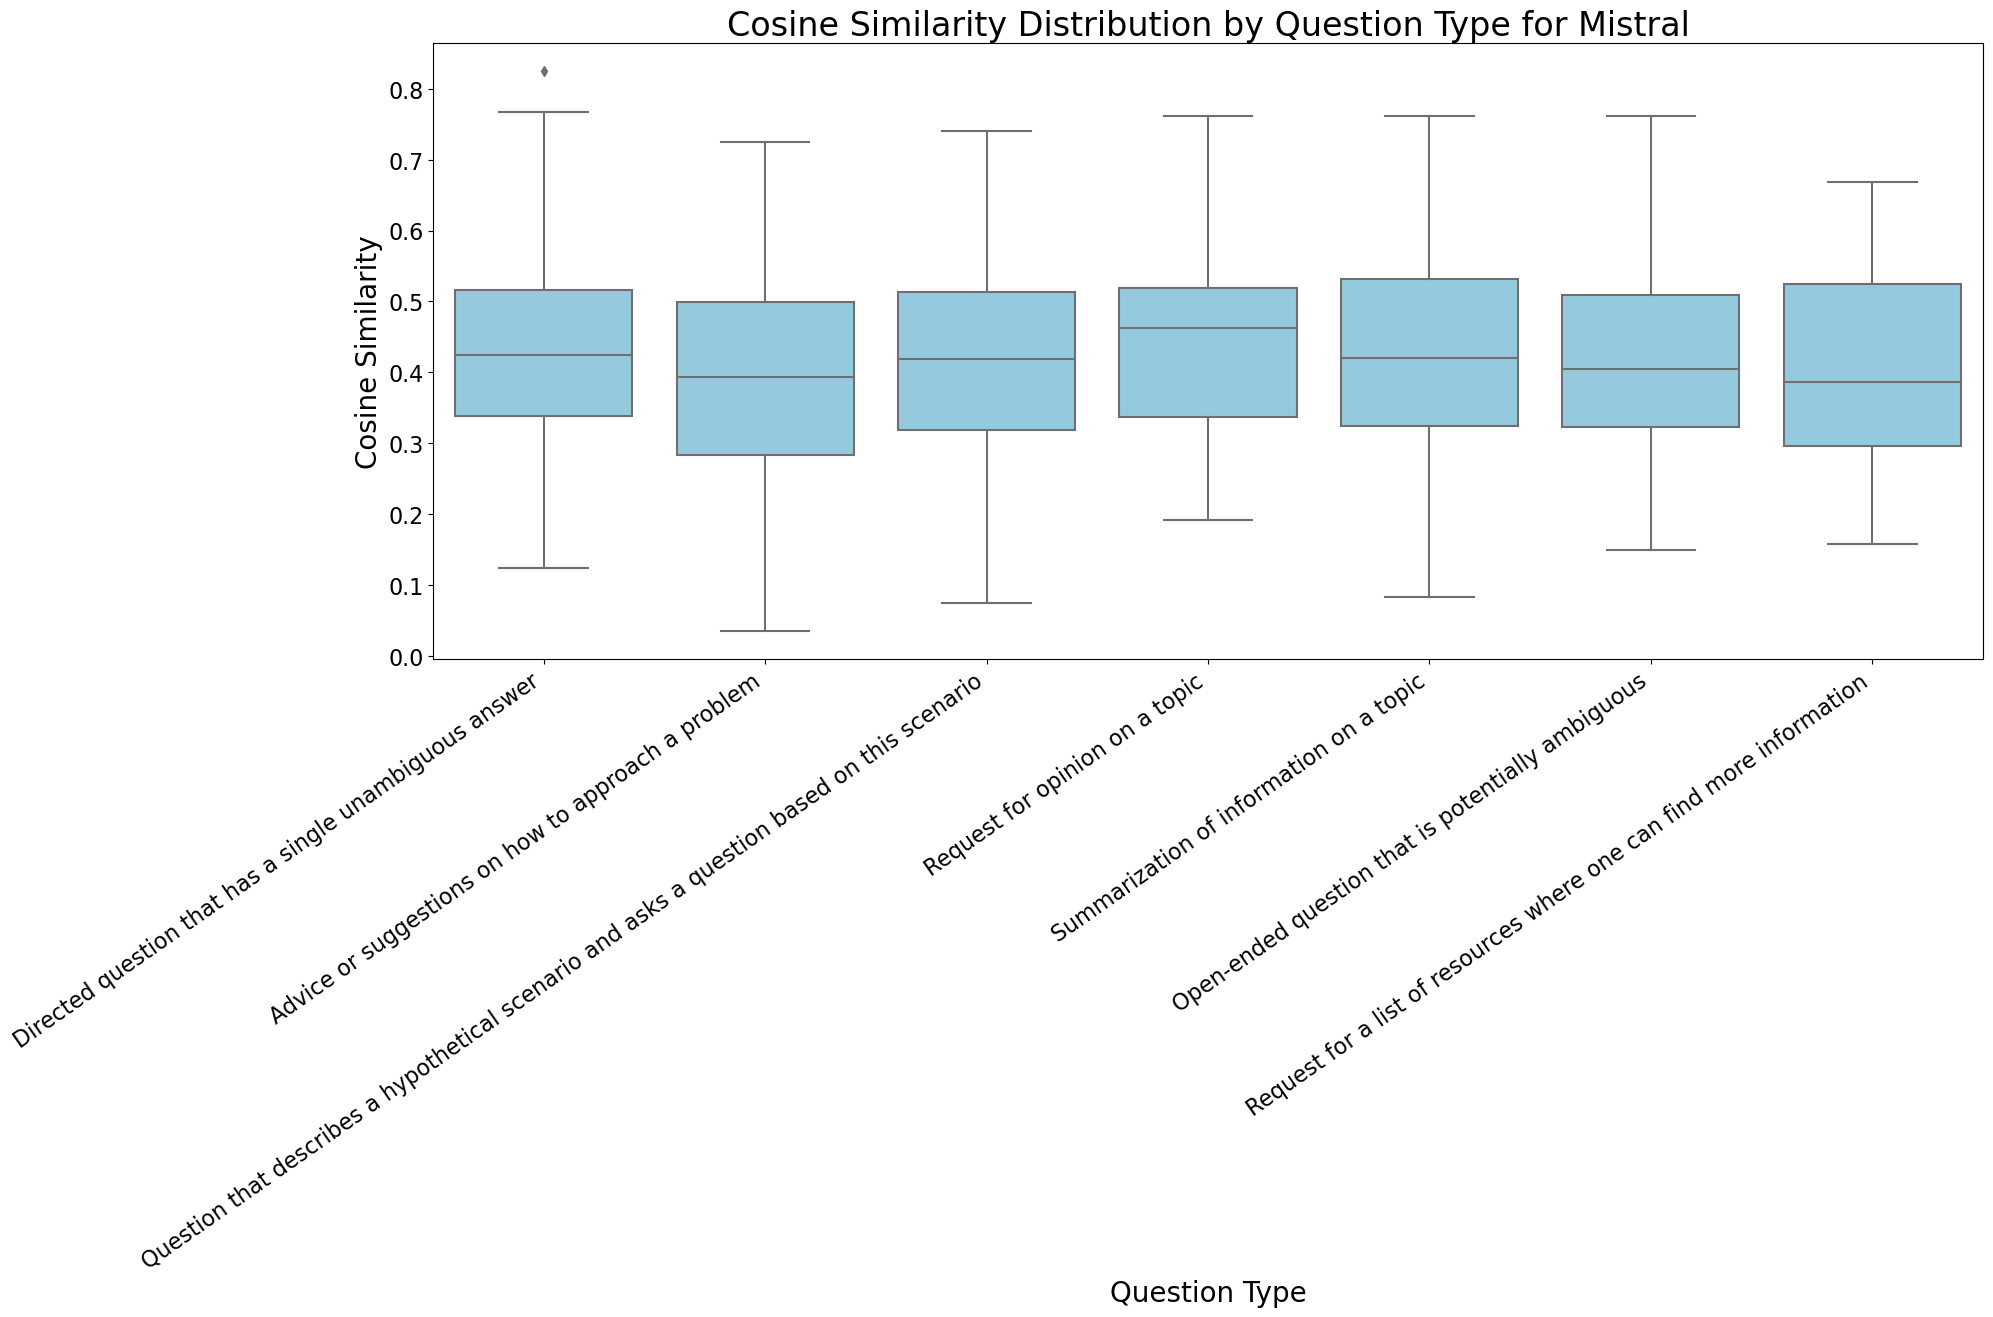

In [66]:
plot_by_question_type(cosine_mistral_exploded, "Cosine Similarity", "Mistral")

In [35]:
# Clean specific fields because there is overlap 
category_map = {
    'Oncology': ['Oncology', 'Oncology Pharmacist', 'oncology'],
    'Pharmacy': ['Pharmacist', 'Pharmacy', 'Pharmacy field', 'pharmacist', 'Dispensery'],
    'Psychology/Psychiatry': ['Clinical Psychologist', 'Psychiatry', 'Psychology', 'Psychotherapy', 'psychiatrist', 'psychology'],
    'Nursing/Midwifery': ['Nursing', 'Midwifery', 'Casualty Nurse', 'Critical care', 'nurse ', 'registered nurse in trauma', 'midwifery'],
    'Medicine/Surgery': ['General medicine', 'General Medicine', 'General practitioner', 'Doctor of Medicine', 'Surgeon', 'Emergency Medicine', 'Internal medicine', 'internal medicine', 'Pediatrician', 'General Physician', 'General medical'],
    'Cardiology': ['Cardiology'],
    'Neurology': ['Neurology', 'Neuroscience researcher'],
    'Clinical Research': ['Clinical Research', 'Medical research, clinical studies', 'Research scientist'],
    'Dentistry': ['Dentistry', 'dentist'],
    'Biomedical Engineering/Science': ['Biomedical Science', 'Biomedical engineering. Main area of work is developing primary health care equipment.', 'Biomedical technologist', 'biomedical science'],
    'Allied Health': ['Audiologist', 'Audiology', 'Dietician/ Nutritionist', 'Occupational Therapy', 'Physiotherapy', 'Speech and Language Therapy'],
    'Radiology': ['Radiology'],
    'Public Health/Safety': ['Emergency Planning', 'Patient Safety', 'Occupational Health, Environment and Safety'],
    'Healthcare Support': ['Care worker', 'Support Work', 'social worker'],
    'Others': ['General', 'Healthcare', 'Pharmaceutical industry', 'Sales rep in medicines']
}

# Create a function to map each field to its broad category
def map_to_category(field):
    for category, keywords in category_map.items():
        if field in keywords:
            return category
    return 'Others'

In [36]:
cosine_medchat["Broad Field"] = cosine_medchat['Specific Field'].apply(map_to_category)
cosine_biomistral["Broad Field"] = cosine_biomistral['Specific Field'].apply(map_to_category)
bert_medchat["Broad Field"] = bert_medchat['Specific Field'].apply(map_to_category)
bert_biomistral["Broad Field"] = bert_biomistral['Specific Field'].apply(map_to_category)
cosine_gpt["Broad Field"] = cosine_gpt['Specific Field'].apply(map_to_category)
bert_gpt["Broad Field"] = bert_gpt['Specific Field'].apply(map_to_category)

cosine_mistral["Broad Field"] = cosine_mistral['Specific Field'].apply(map_to_category)
bert_mistral["Broad Field"] = bert_mistral['Specific Field'].apply(map_to_category)

In [37]:
def plot_by_specific_field(og_df, score, model):
    plt.figure(figsize=(15, 10))
    sns.boxplot(x='Broad Field', y=score, data=og_df, color='skyblue')
    plt.title(f"{score} Distribution by Specific Field for {model}", fontsize=18)
    plt.xlabel('Specific Field', fontsize=18)
    plt.ylabel(f"{score}", fontsize=18)
    plt.xticks(rotation=45, ha="right", fontsize=18)
    plt.tight_layout()

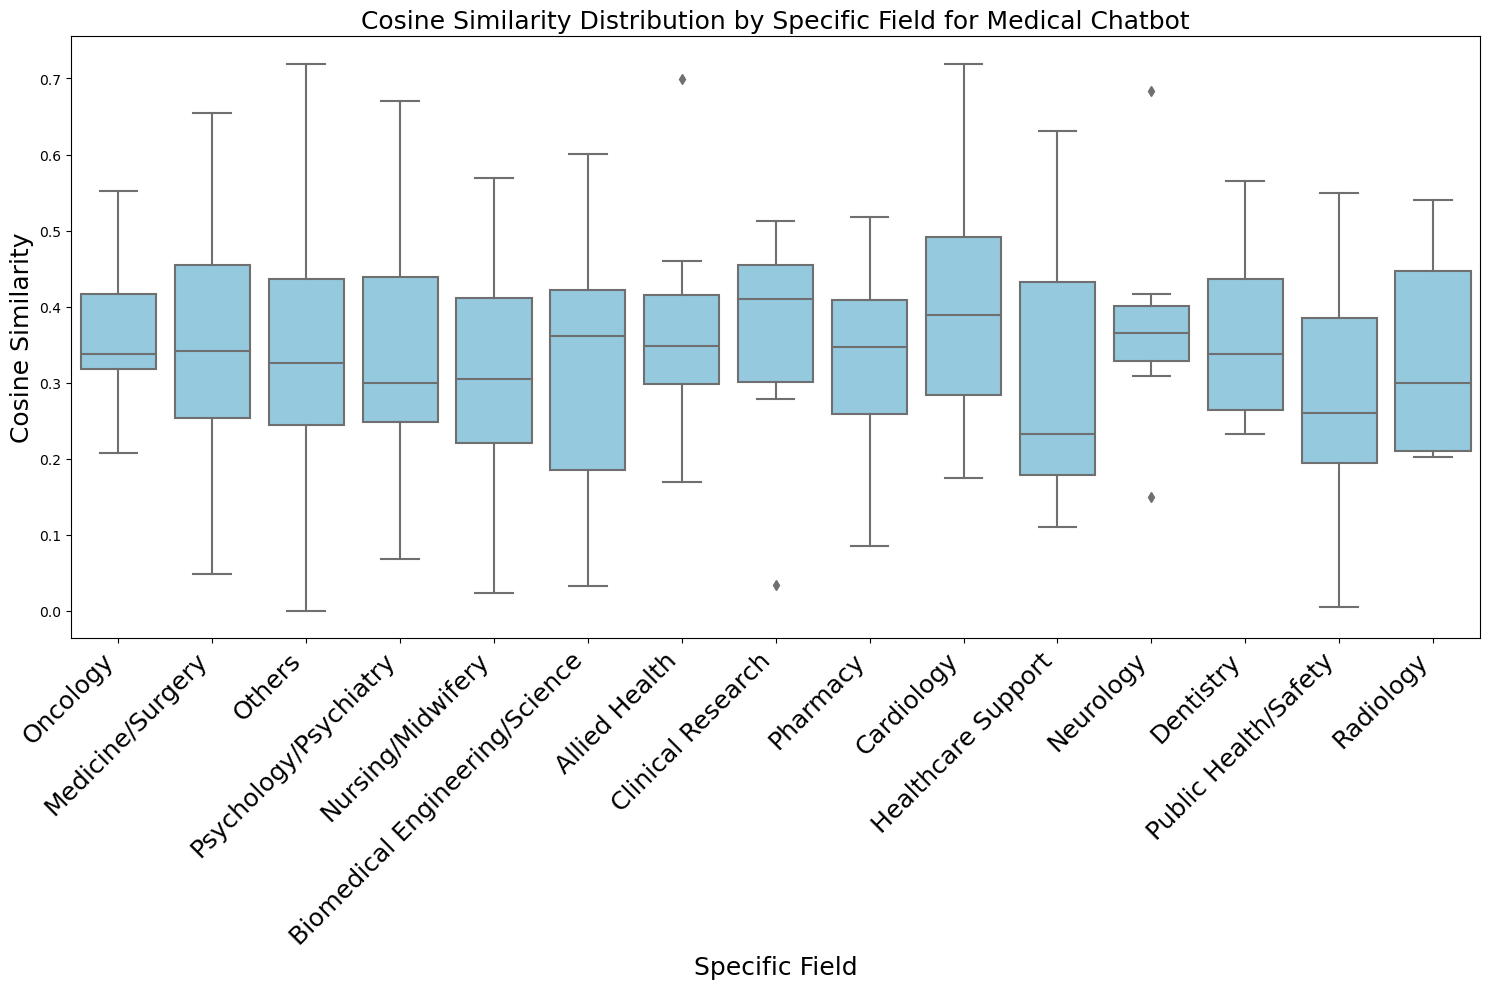

In [38]:
plot_by_specific_field(cosine_medchat, "Cosine Similarity", "Medical Chatbot")

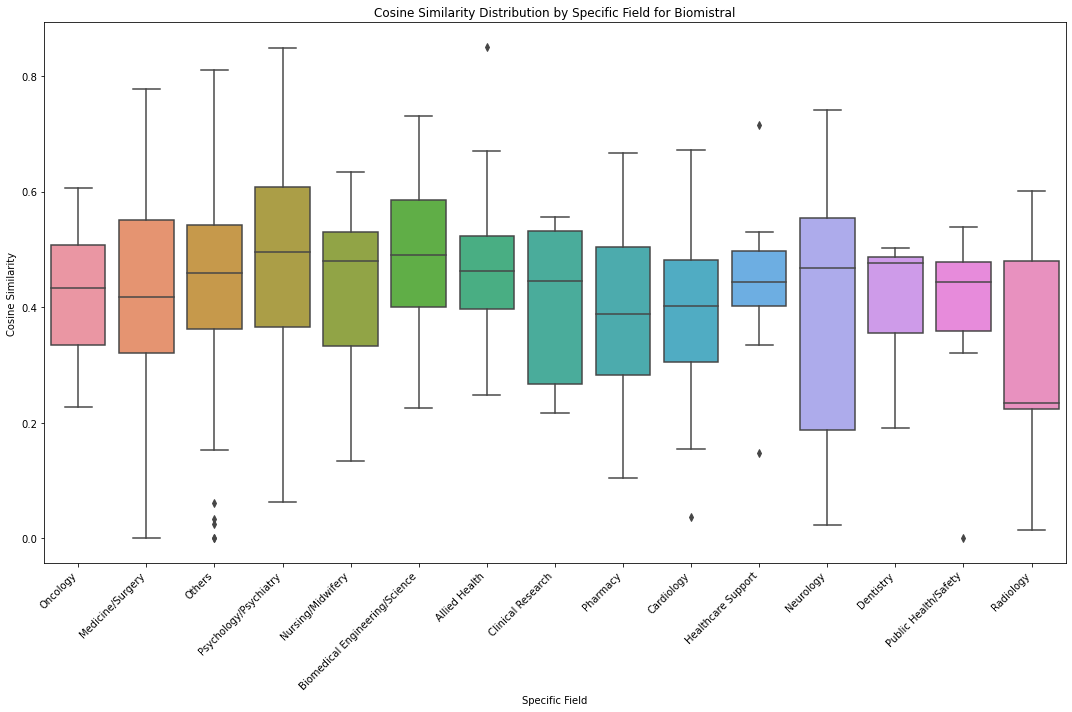

In [105]:
plot_by_specific_field(cosine_biomistral, "Cosine Similarity", "Biomistral")

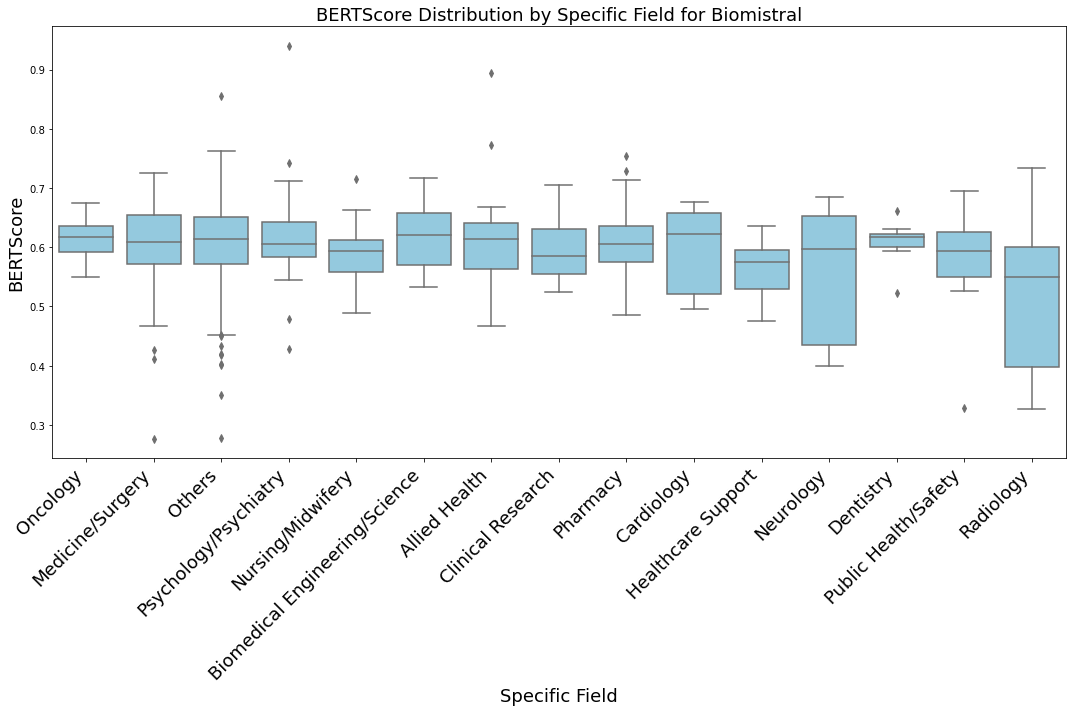

In [241]:
plot_by_specific_field(bert_biomistral, "BERTScore", "Biomistral")

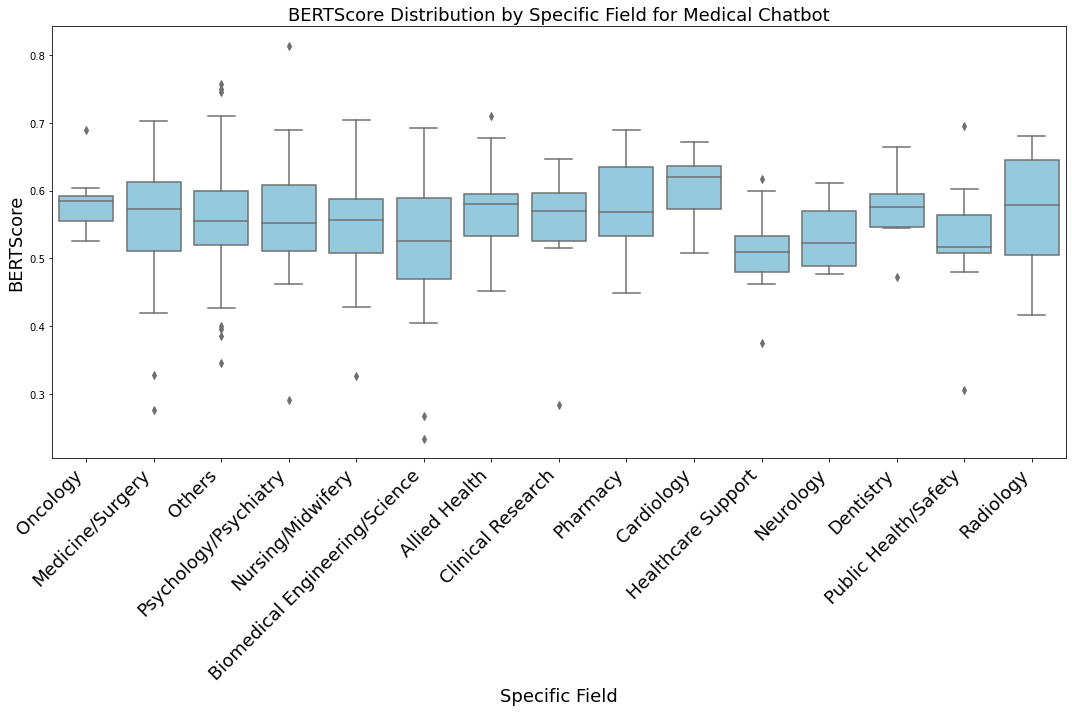

In [242]:
plot_by_specific_field(bert_medchat, "BERTScore", "Medical Chatbot")

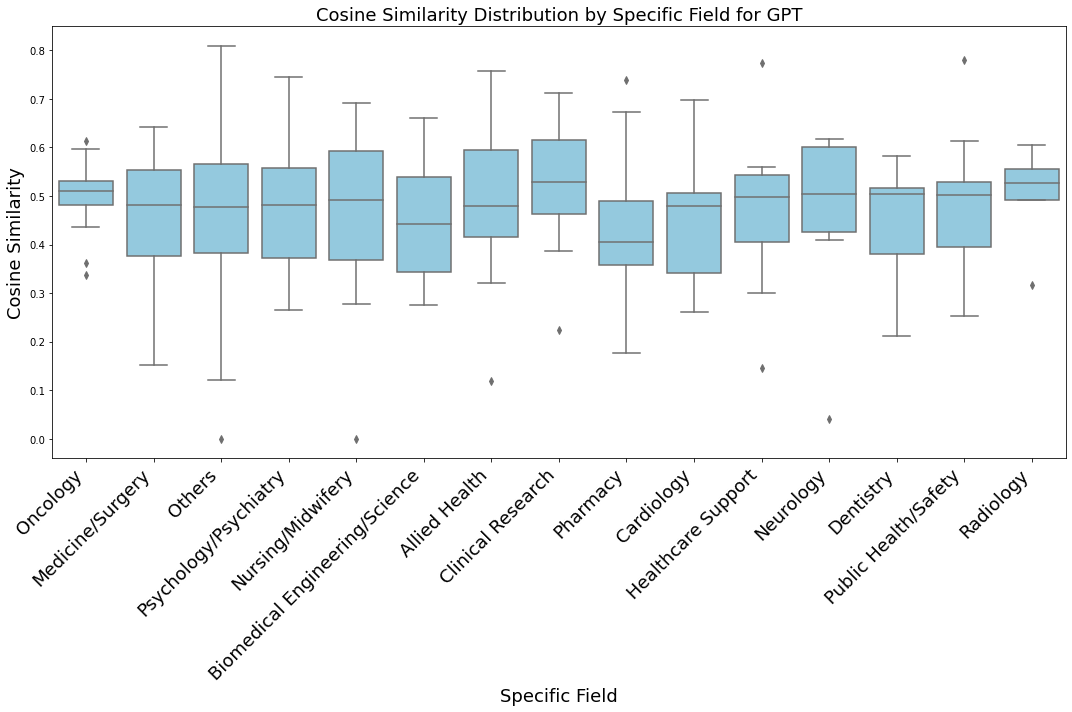

In [243]:
plot_by_specific_field(cosine_gpt, "Cosine Similarity", "GPT")

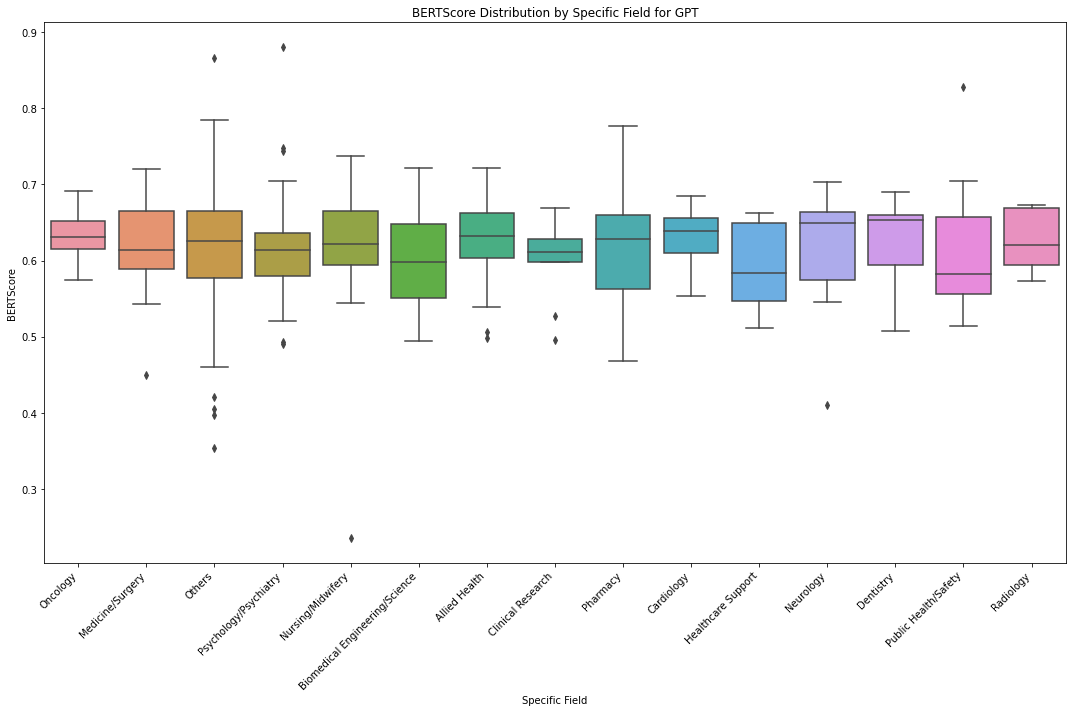

In [136]:
plot_by_specific_field(bert_gpt, "BERTScore", "GPT")

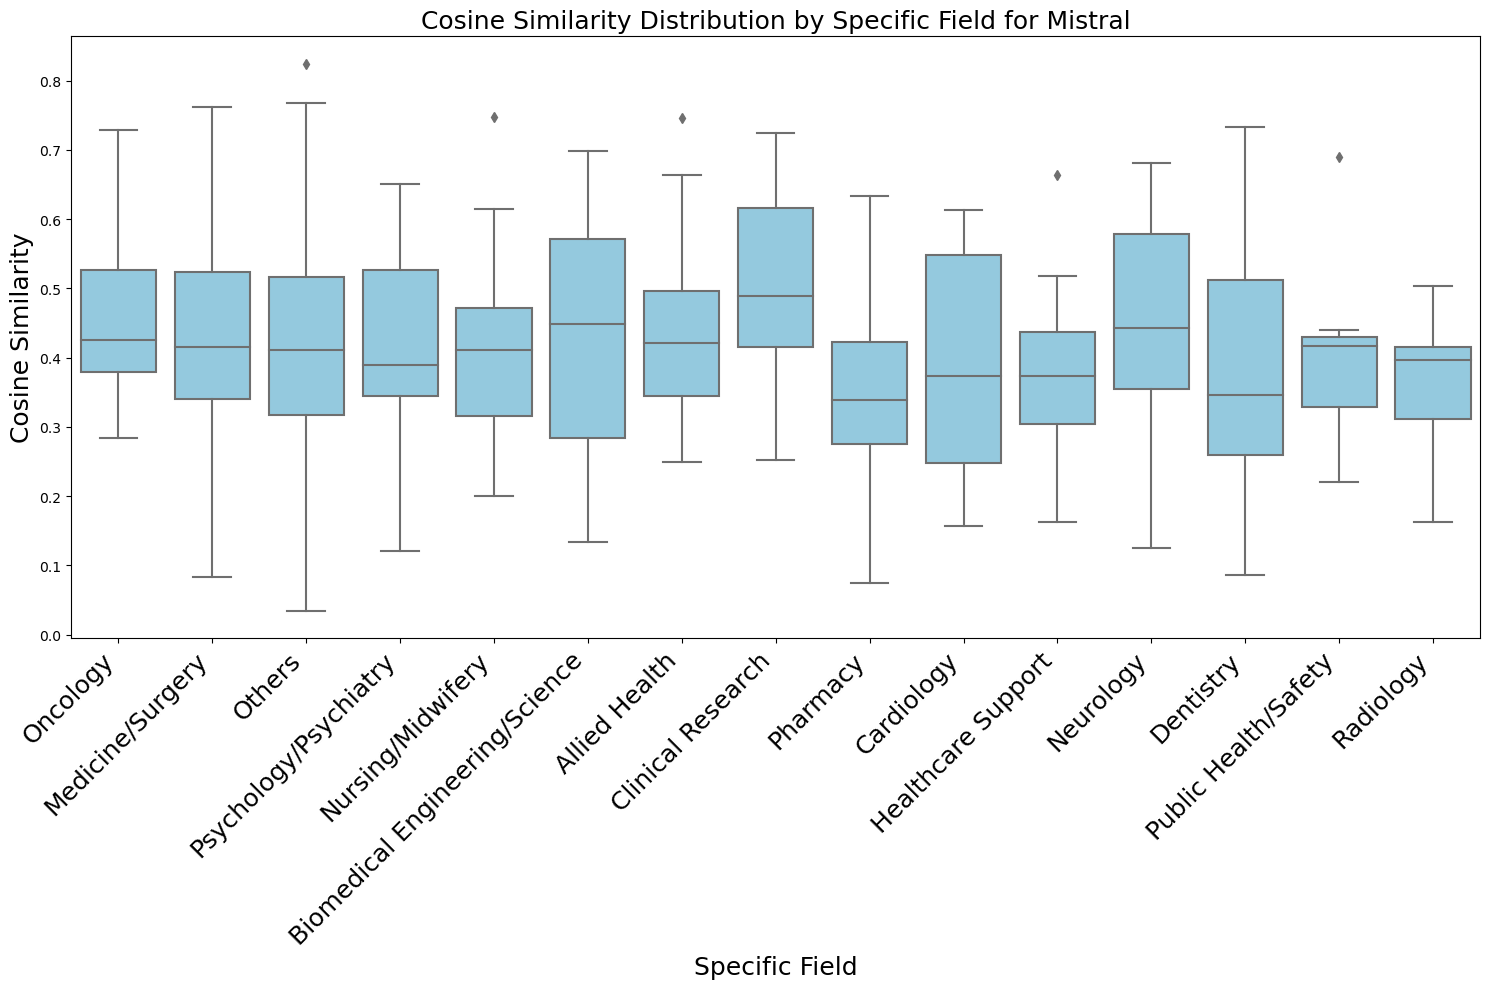

In [39]:
plot_by_specific_field(cosine_mistral, "Cosine Similarity", "Mistral")

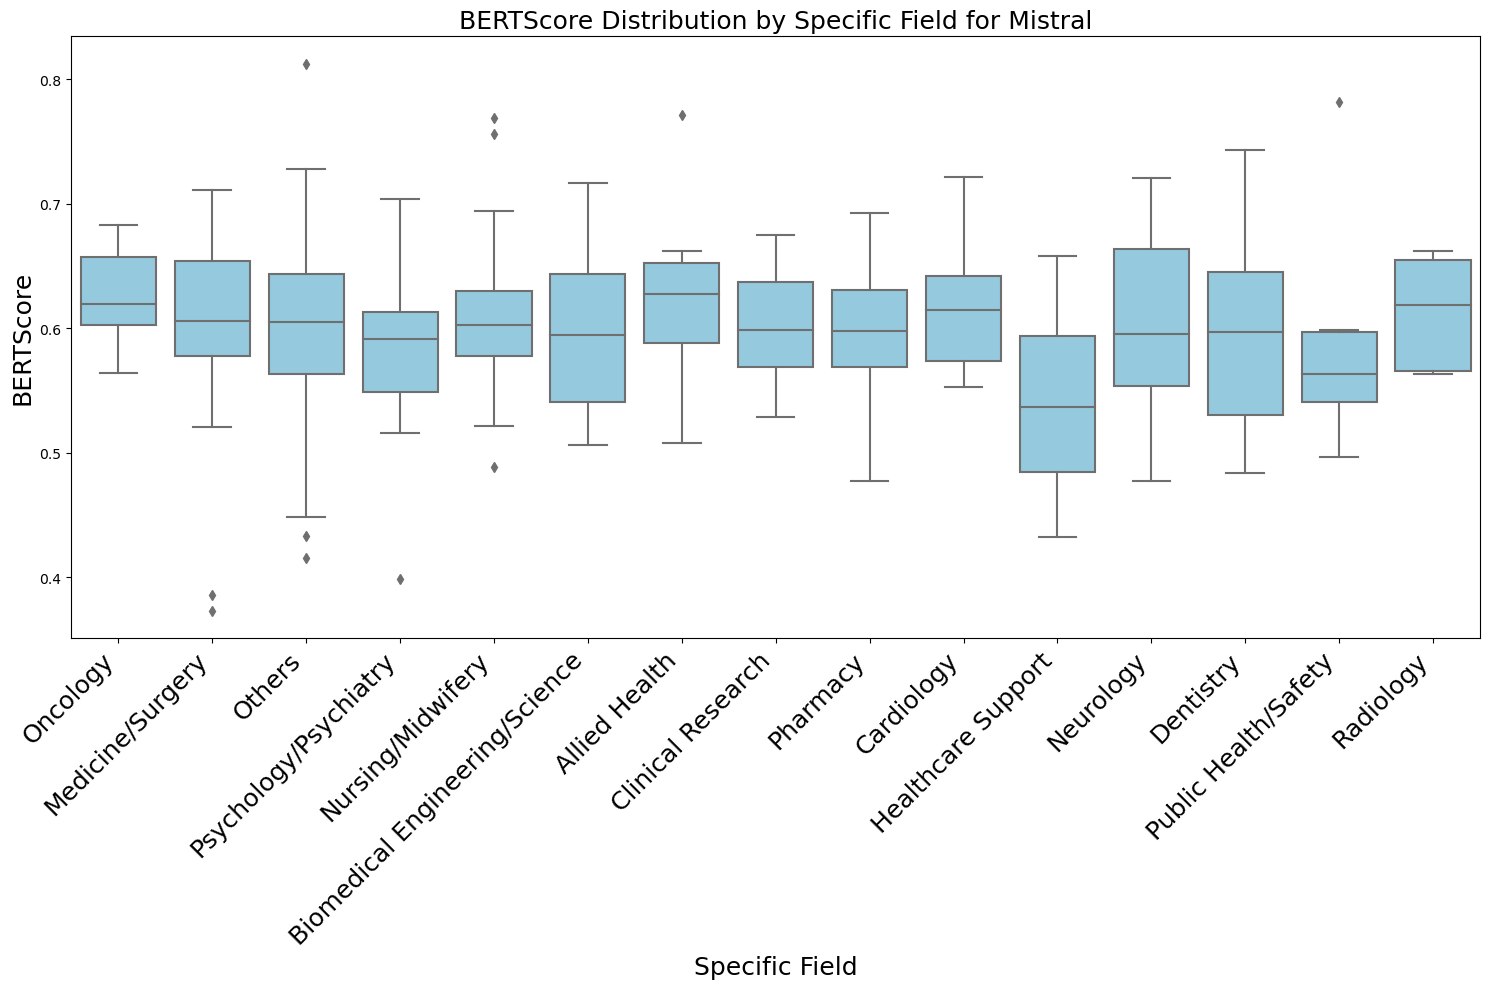

In [40]:
plot_by_specific_field(bert_mistral, "BERTScore", "Mistral")

# Plot all models together

In [82]:
def plot_by_question_type(dataframes, score):
    # Combine data from all models for each question type
    combined_data = pd.concat(dataframes)
    
    # Plot boxplots
    plt.figure(figsize=(20, 12))
    sns.boxplot(x='Question Type', y=score, hue='Model', data=combined_data)
    plt.title(f"{score} Distribution by Question Type for All Models", fontsize=18)
    plt.xlabel('Question Type', fontsize=18)
    plt.ylabel(score, fontsize=18)
    plt.xticks(rotation=30, ha="right", fontsize=15)
    plt.tight_layout()
    plt.legend(title='Model')
    plt.tight_layout()

/var/folders/3y/2p_bs7xd4lz32fylyzcm71cr0000gn/T/ipykernel_4150/517726798.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


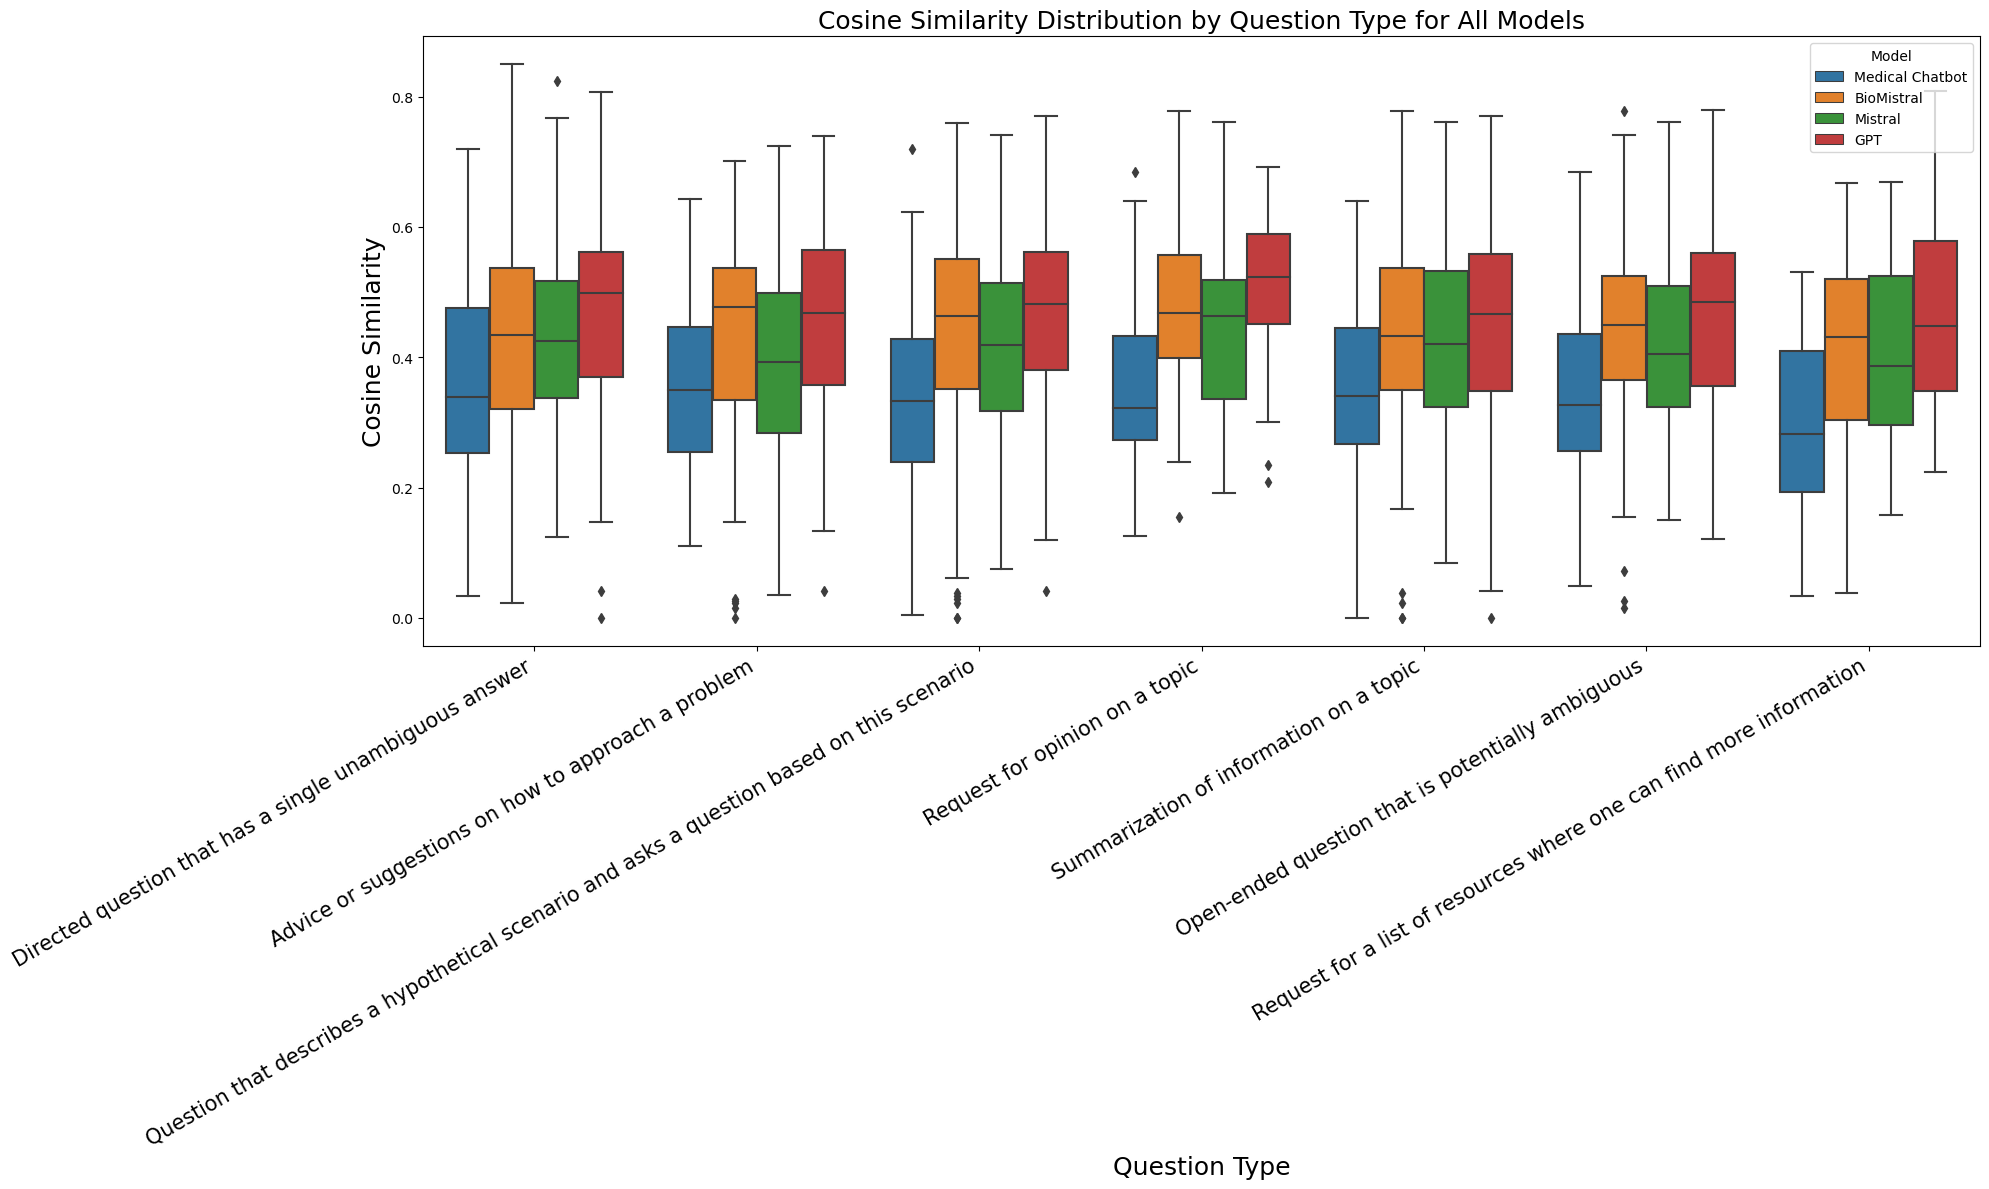

In [83]:
plot_by_question_type([cosine_medchat_exploded.assign(Model='Medical Chatbot'),
                       cosine_biomistral_exploded.assign(Model='BioMistral'),
                       cosine_mistral_exploded.assign(Model='Mistral'),
                       cosine_gpt_exploded.assign(Model='GPT')], "Cosine Similarity")

/var/folders/3y/2p_bs7xd4lz32fylyzcm71cr0000gn/T/ipykernel_4150/517726798.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


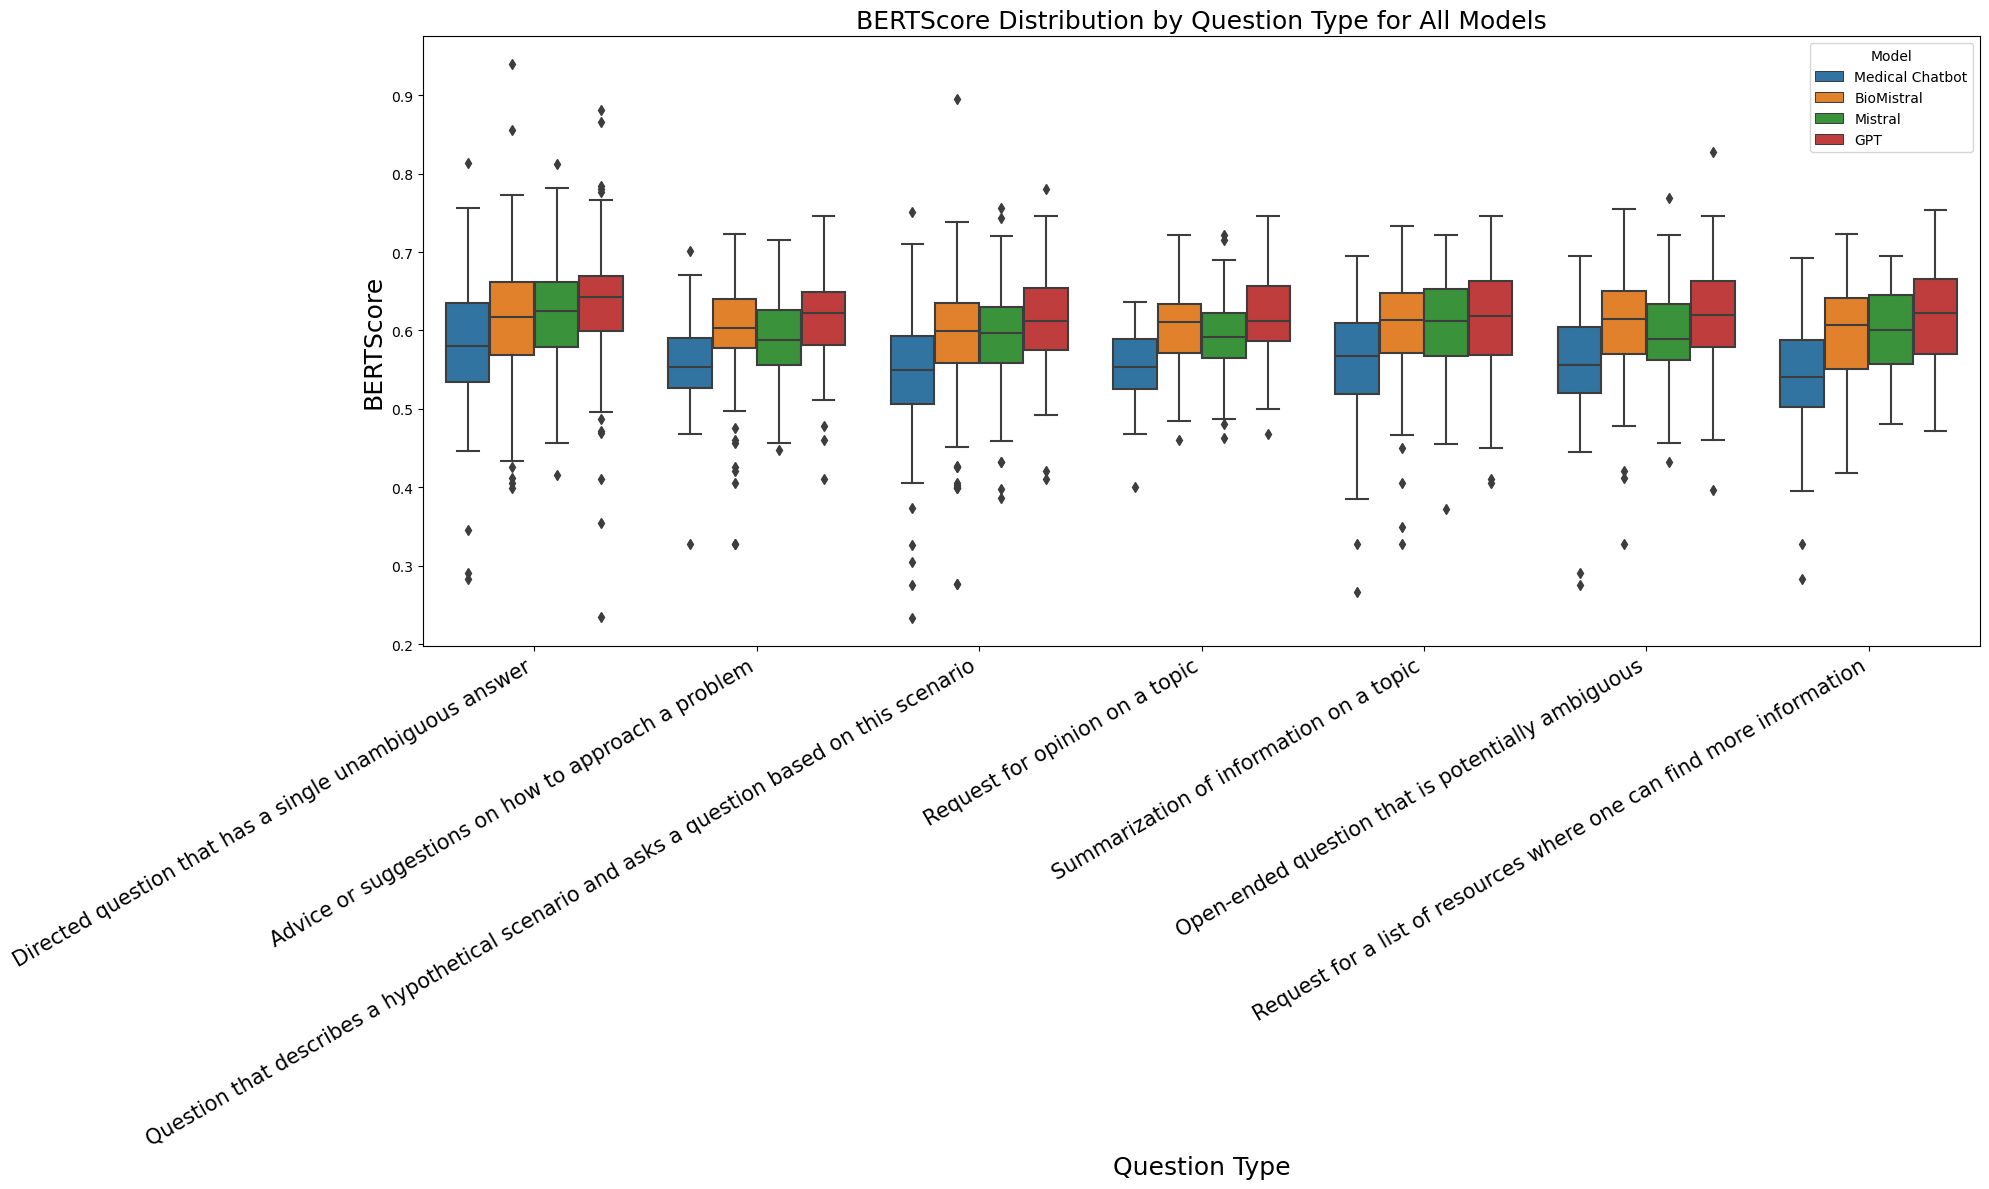

In [44]:
plot_by_question_type([bert_medchat_exploded.assign(Model='Medical Chatbot'),
                       bert_biomistral_exploded.assign(Model='BioMistral'),
                       bert_mistral_exploded.assign(Model='Mistral'),
                       bert_gpt_exploded.assign(Model='GPT')], "BERTScore")

In [84]:
def plot_by_specific_field(dataframes, score):
    # Combine data from all models for each question type
    combined_data = pd.concat(dataframes)
    
    # Plot boxplots
    plt.figure(figsize=(20, 12))
    sns.boxplot(x='Broad Field', y=score, hue='Model', data=combined_data)
    plt.title(f"{score} Distribution by Specific Field for All Models", fontsize=18)
    plt.xlabel('Specific Field', fontsize=18)
    plt.ylabel(score, fontsize=18)
    plt.xticks(rotation=45, ha="right", fontsize=15)
    plt.yticks(fontsize=12)
    plt.tight_layout()

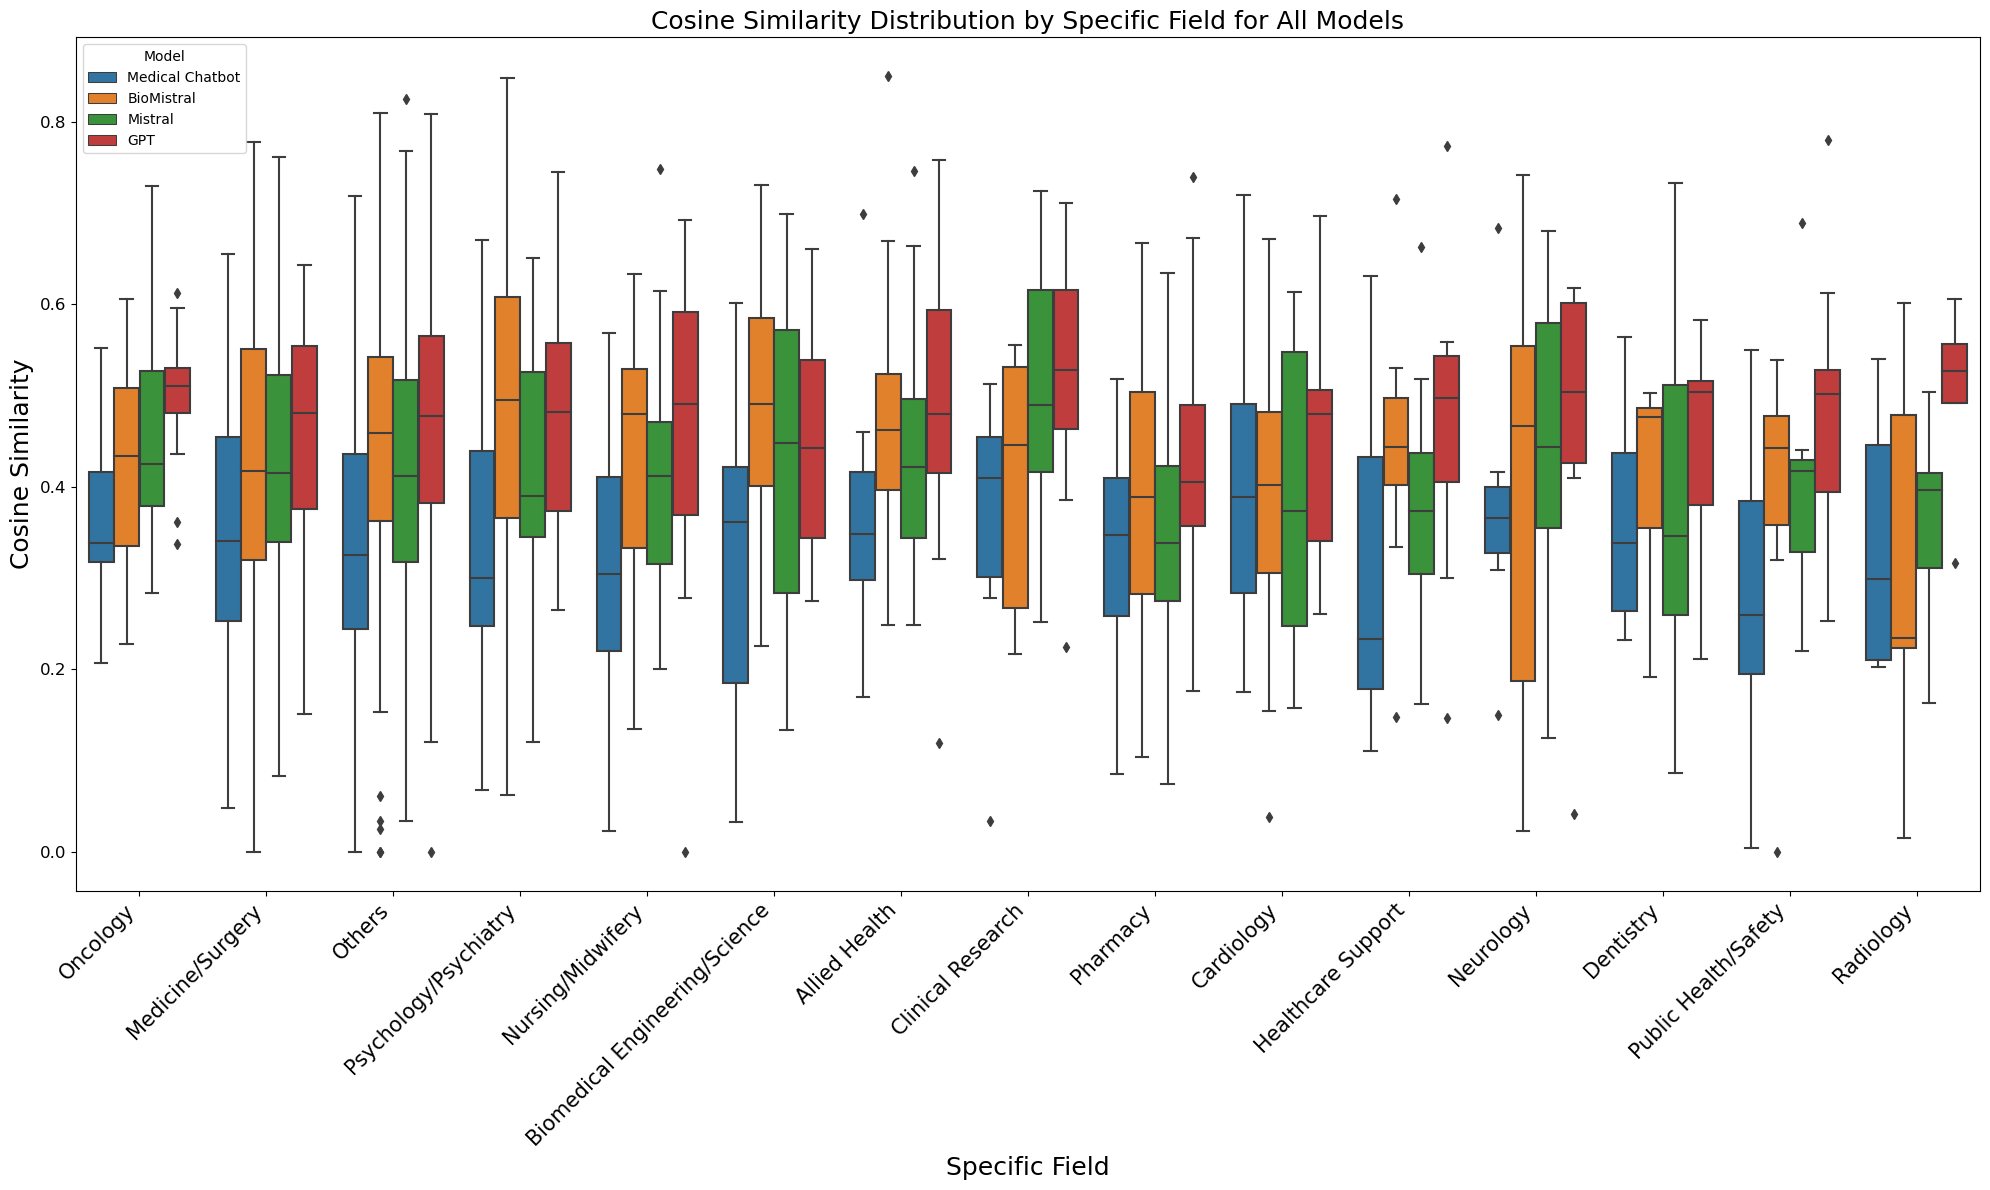

In [85]:
plot_by_specific_field([cosine_medchat.assign(Model='Medical Chatbot'),
                       cosine_biomistral.assign(Model='BioMistral'),
                       cosine_mistral.assign(Model='Mistral'),
                       cosine_gpt.assign(Model='GPT')], "Cosine Similarity")

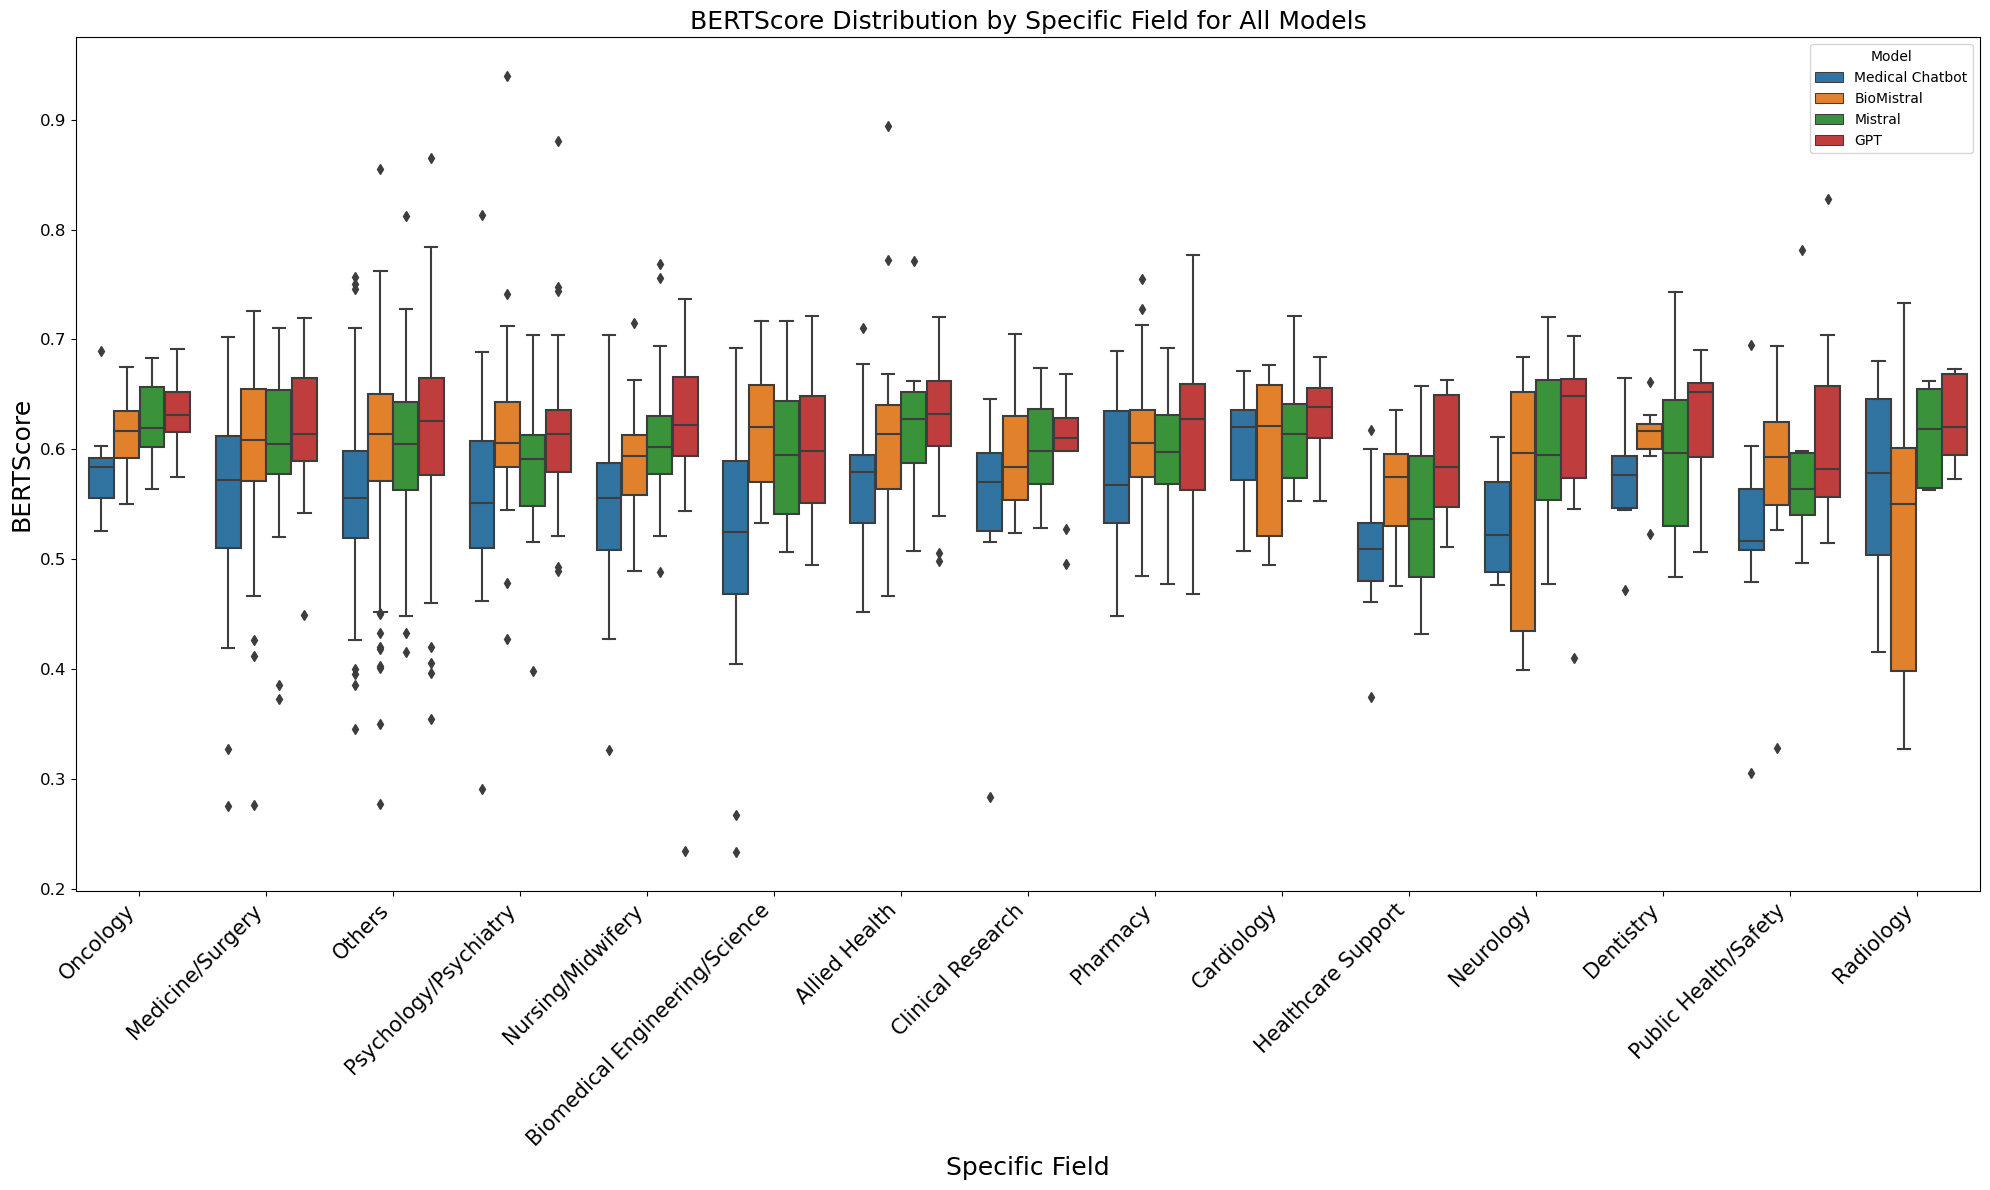

In [87]:
plot_by_specific_field([bert_medchat.assign(Model='Medical Chatbot'),
                       bert_biomistral.assign(Model='BioMistral'),
                       bert_mistral.assign(Model='Mistral'),
                       bert_gpt.assign(Model='GPT')], "BERTScore")

# QAFactEval 

In [8]:
print(os.getcwd())

# os.chdir("AlignScore/src")
# print(os.getcwd())

/Users/maansishroff/Documents/SeniorSpring/LLM


In [10]:
print(os.getcwd())

from alignscore import AlignScore

os.chdir("../../")
print(os.getcwd())

/Users/maansishroff/Documents/SeniorSpring/LLM/AlignScore/src
/Users/maansishroff/Documents/SeniorSpring/LLM
